In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_loss
from utils.functions import green
from utils.loss_weight import update_lambda, loss_grad_norm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [-0.4, 0.4]
#k = 2 * np.pi * 20 / 1500 * 100
L_pml = 0.4
sigma = 5
strentch = 5

In [8]:
k1 = 2 * np.pi * 20 / 1500 * 100
k2 = 2 * np.pi * 20 / 1700 * 100
rho1 = 1000
rho2 = 2000

def wave_number(x, y, k1=k1, k2=k2, medium='both'):
    k = k1 * torch.ones_like(x)
    if medium == 'both':
        ind = y < 0
        k[ind] = k2
    elif medium == 'water':
        k = k
    elif medium == 'ground':
        k = k2 * torch.ones_like(x)
    else:
        print('error: medium selected is wrong')
    return k

In [9]:
## hyperparameter
#w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(5e3)
learning_rate = 2e-5

In [10]:
def get_dataset(Lx, Ly, device=device):
    # water
    x1, y1 = 2 * Lx * torch.rand(100000, 1) - Lx, Ly * torch.rand(100000, 1)
    x, y = torch.linspace(-Lx, Lx, 500), torch.linspace(0, Ly, 100)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x1[-len(x):, :], y1[-len(x):, :] = x, y

    # seabed
    x2, y2 = 2 * Lx * torch.rand(100000, 1) - Lx, -Ly * torch.rand(100000, 1)
    x, y = torch.linspace(-Lx, Lx, 500), torch.linspace(-Ly, 0, 100)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x2[-len(x):, :], y2[-len(x):, :] = x, y

    return torch.tensor(x1, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y1, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(x2, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y2, dtype=torch.float32, requires_grad=False).to(device)

def data_iter(batch_size, x1, y1, x2, y2):
    import random as rd
    num = len(x1)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x1[batch_id], y1[batch_id], x2[batch_id], y2[batch_id]

In [11]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(-y - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, k, src=src, L_pml=L_pml, sigma0=sigma):
    x, y = x.requires_grad_(), y.requires_grad_()

    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)

    p = model(torch.cat([x, y], dim=-1))
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)

    res = (1/strentch) ** 2 * pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p)
    return (res ** 2).mean()

def loss_bd(model, Lx, Ly, src, n_coll=1000, device=device):
    L0 = Lx
    x, y = torch.linspace(-L0, L0, n_coll), torch.ones(n_coll)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    res = p + green(x, y, src, k=k1, strentch=strentch)
    return (res ** 2).mean()

def loss_interface(model1, model2, Lx, Ly, src, k=k1, rho1=rho1, rho2=rho2, n_coll=1000, device=device):
    L0 = Lx
    x, y = torch.linspace(-L0, L0, n_coll), torch.zeros(n_coll)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    
    epsilon = 0.001
    g1, g2 = green(x, y + epsilon, src, k, strentch=strentch), green(x, y - epsilon, src, k, strentch=strentch)
    gy = (g1 - g2) / (2 * epsilon)
    g = green(x, y, src, k=k, strentch=strentch)

    xy = torch.cat([x, y], dim=-1)
    p1, p2 = model1(xy), model2(xy)
    py1_real = torch.autograd.grad(p1[:, 0:1].sum(), y, create_graph=True)[0]
    py1_imag = torch.autograd.grad(p1[:, 1:2].sum(), y, create_graph=True)[0]
    py2_real = torch.autograd.grad(p2[:, 0:1].sum(), y, create_graph=True)[0]
    py2_imag = torch.autograd.grad(p2[:, 1:2].sum(), y, create_graph=True)[0]
    py1 = torch.cat([py1_real, py1_imag], dim=-1)
    py2 = torch.cat([py2_real, py2_imag], dim=-1)
    res1 = (py1 + gy) / rho1 - py2 / rho2
    res2 = p1 + g - p2
    return (res1 ** 2).mean(), (res2 ** 2).mean()

In [12]:
#water_net = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
#water_net.apply(sine_init)
#water_net.net[0].apply(first_layer_sine_init)
#bed_net = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
#bed_net.apply(sine_init)
#bed_net.net[0].apply(first_layer_sine_init)
import joblib
state_dict = joblib.load('model_water.joblib')
water_net = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
water_net.load_state_dict(state_dict)
state_dict = joblib.load('model_seabed.joblib')
bed_net = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
bed_net.load_state_dict(state_dict)
lamb = [1, 1, 1, 1]
#loss_bound_hist = []
#loss_pde_hist = []
#loss_src_hist = []
#lamb_bound_hist = []
#lamb_pde_hist = []
#lamb_src_hist = []
l_lst = []
l_lst1 = []
l_lst2 = []
n_lamb_update = 50

In [13]:
n_epochs = int(3e3)
learning_rate = 8e-6
optimizer = torch.optim.Adam(list(water_net.parameters())+list(bed_net.parameters()), lr=learning_rate)
#from torch.optim.lr_scheduler import MultiStepLR
#milestones = [1000]
#scheduler = MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)

In [60]:
water_net, bed_net = water_net.to(device), bed_net.to(device)

In [14]:
x1, y1, x2, y2 = get_dataset(Lx, Ly)
i = 0
for epoch in tqdm(range(n_epochs)):
    if epoch == 1000:
        optimizer = torch.optim.Adam(list(water_net.parameters())+list(bed_net.parameters()), lr=5e-6)
    if epoch == 3000:
        optimizer = torch.optim.Adam(list(water_net.parameters())+list(bed_net.parameters()), lr=2e-6)
    if epoch == 4000:
        optimizer = torch.optim.Adam(list(water_net.parameters())+list(bed_net.parameters()), lr=1e-6)
    for x_w, y_w, x_g, y_g in data_iter(5000, x1, y1, x2, y2):
        optimizer.zero_grad()
        loss_pde1, loss_pde2 = loss_fn(water_net, x_w, y_w, k1), loss_fn(bed_net, x_g, y_g, k2)
        loss_top = loss_bd(water_net, Lx, Ly, src)
        loss_inter1, loss_inter2 = loss_interface(water_net, bed_net, Lx, Ly, src)
        loss_lst = [loss_pde1, loss_top, loss_inter1, loss_inter2]
        i += 1
        if i % 50 == 0: 
            lamb = update_lambda(water_net, loss_lst, lamb, 0.9)
        loss = lamb[0] * loss_pde1 + lamb[0] * loss_pde2 + lamb[1] * loss_top + lamb[2] * loss_inter1 + lamb[3] * loss_inter2
         
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Loss_pde1: {loss_pde1.item()}, Loss_pde2: {loss_pde2.item()}, Loss_interface: {loss_inter1.item()}')
    
    l_lst.append(loss)
    l_lst1.append(loss_pde1)
    l_lst2.append(loss_pde2)

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_6600/1380383876.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x1, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_6600/1380383876.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y1, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_6600/1380383876.py

Epoch 5, Loss: 0.0018040969735011458, Loss_pde1: 0.0006197440670803189, Loss_pde2: 0.0004427753447089344, Loss_interface: 2.3233648078352376e-12


  0%|          | 10/3000 [00:40<3:20:37,  4.03s/it]

Epoch 10, Loss: 0.0011937569361180067, Loss_pde1: 0.0006158113246783614, Loss_pde2: 0.00027450406923890114, Loss_interface: 5.5672389034965367e-14


  0%|          | 15/3000 [01:00<3:21:10,  4.04s/it]

Epoch 15, Loss: 0.0010279819834977388, Loss_pde1: 0.0006363621796481311, Loss_pde2: 0.00024584049242548645, Loss_interface: 1.60736682075285e-14


  1%|          | 20/3000 [01:21<3:22:11,  4.07s/it]

Epoch 20, Loss: 0.0011499368119984865, Loss_pde1: 0.0006828861078247428, Loss_pde2: 0.00028331263456493616, Loss_interface: 6.339788855566977e-14


  1%|          | 25/3000 [01:41<3:25:47,  4.15s/it]

Epoch 25, Loss: 0.0028342579025775194, Loss_pde1: 0.0012554496061056852, Loss_pde2: 0.0006866951007395983, Loss_interface: 2.403867307033264e-13


  1%|          | 30/3000 [02:02<3:28:18,  4.21s/it]

Epoch 30, Loss: 0.001322467578575015, Loss_pde1: 0.0005407629651017487, Loss_pde2: 0.00037251648609526455, Loss_interface: 1.2229564691663974e-13


  1%|          | 35/3000 [02:23<3:31:09,  4.27s/it]

Epoch 35, Loss: 0.0019093817099928856, Loss_pde1: 0.0006984702777117491, Loss_pde2: 0.0004839168395847082, Loss_interface: 2.0431815690290928e-13


  1%|▏         | 40/3000 [02:45<3:40:17,  4.47s/it]

Epoch 40, Loss: 0.0026697544381022453, Loss_pde1: 0.0010130389127880335, Loss_pde2: 0.0007343355100601912, Loss_interface: 2.1707092232644415e-13


  2%|▏         | 45/3000 [03:08<3:47:20,  4.62s/it]

Epoch 45, Loss: 0.0016418277518823743, Loss_pde1: 0.0005756772006861866, Loss_pde2: 0.0004906957037746906, Loss_interface: 1.2487836556929893e-13


  2%|▏         | 50/3000 [03:31<3:49:47,  4.67s/it]

Epoch 50, Loss: 0.002159249735996127, Loss_pde1: 0.0005677122971974313, Loss_pde2: 0.0006533362902700901, Loss_interface: 2.303867545957322e-13


  2%|▏         | 55/3000 [03:54<3:49:57,  4.69s/it]

Epoch 55, Loss: 0.0020982639398425817, Loss_pde1: 0.0006410644273273647, Loss_pde2: 0.0005482508568093181, Loss_interface: 1.9449654560521612e-13


  2%|▏         | 60/3000 [04:17<3:51:48,  4.73s/it]

Epoch 60, Loss: 0.0021767783910036087, Loss_pde1: 0.0006174186710268259, Loss_pde2: 0.0005070029874332249, Loss_interface: 2.9507125909322696e-13


  2%|▏         | 65/3000 [04:41<3:52:44,  4.76s/it]

Epoch 65, Loss: 0.0028849656227976084, Loss_pde1: 0.0005329647101461887, Loss_pde2: 0.0006605759263038635, Loss_interface: 4.3243514780307024e-13


  2%|▏         | 70/3000 [05:04<3:52:44,  4.77s/it]

Epoch 70, Loss: 0.0010382963810116053, Loss_pde1: 0.0004292587691452354, Loss_pde2: 0.0003300592361483723, Loss_interface: 5.721462935587632e-14


  2%|▎         | 75/3000 [05:28<3:52:00,  4.76s/it]

Epoch 75, Loss: 0.0013501814100891352, Loss_pde1: 0.00047413204447366297, Loss_pde2: 0.00046059006126597524, Loss_interface: 8.739024586444655e-14


  3%|▎         | 80/3000 [05:51<3:51:34,  4.76s/it]

Epoch 80, Loss: 0.0011525992304086685, Loss_pde1: 0.0004375896241981536, Loss_pde2: 0.00036382945836521685, Loss_interface: 5.5883242640591274e-14


  3%|▎         | 85/3000 [06:15<3:51:23,  4.76s/it]

Epoch 85, Loss: 0.0014183662133291364, Loss_pde1: 0.0004962694947607815, Loss_pde2: 0.0006085128406994045, Loss_interface: 6.645263495291126e-14


  3%|▎         | 90/3000 [06:38<3:50:50,  4.76s/it]

Epoch 90, Loss: 0.0033687890972942114, Loss_pde1: 0.000992851797491312, Loss_pde2: 0.000828502350486815, Loss_interface: 3.6287850979296876e-13


  3%|▎         | 95/3000 [07:02<3:50:13,  4.76s/it]

Epoch 95, Loss: 0.0013602160615846515, Loss_pde1: 0.0004989845911040902, Loss_pde2: 0.0004296762344893068, Loss_interface: 8.645569069681835e-14


  3%|▎         | 100/3000 [07:25<3:49:51,  4.76s/it]

Epoch 100, Loss: 0.0011182879097759724, Loss_pde1: 0.0004708864144049585, Loss_pde2: 0.0003623342781793326, Loss_interface: 5.2459288134168794e-14


  4%|▎         | 105/3000 [07:49<3:49:59,  4.77s/it]

Epoch 105, Loss: 0.0035124795977026224, Loss_pde1: 0.0008622545283287764, Loss_pde2: 0.0013849498936906457, Loss_interface: 2.640824299689204e-13


  4%|▎         | 110/3000 [08:12<3:49:13,  4.76s/it]

Epoch 110, Loss: 0.000860891246702522, Loss_pde1: 0.00040423081372864544, Loss_pde2: 0.0002959307166747749, Loss_interface: 3.4991391836998453e-14


  4%|▍         | 115/3000 [08:36<3:49:50,  4.78s/it]

Epoch 115, Loss: 0.0015708679566159844, Loss_pde1: 0.00044748897198587656, Loss_pde2: 0.0004193016793578863, Loss_interface: 2.1119722995194962e-13


  4%|▍         | 120/3000 [09:00<3:49:38,  4.78s/it]

Epoch 120, Loss: 0.002055360935628414, Loss_pde1: 0.0004480360366869718, Loss_pde2: 0.0006264500552788377, Loss_interface: 3.090881500397713e-13


  4%|▍         | 125/3000 [09:23<3:49:52,  4.80s/it]

Epoch 125, Loss: 0.0016474452568218112, Loss_pde1: 0.0005130675272084773, Loss_pde2: 0.0008056656806729734, Loss_interface: 6.222125814797988e-14


  4%|▍         | 130/3000 [09:47<3:49:04,  4.79s/it]

Epoch 130, Loss: 0.003813659306615591, Loss_pde1: 0.0008700279286131263, Loss_pde2: 0.0005490337498486042, Loss_interface: 8.536592521193528e-14


  4%|▍         | 135/3000 [10:11<3:48:08,  4.78s/it]

Epoch 135, Loss: 0.001297077164053917, Loss_pde1: 0.0006295783678069711, Loss_pde2: 0.000512406462803483, Loss_interface: 2.6975769979332292e-14


  5%|▍         | 140/3000 [10:34<3:48:11,  4.79s/it]

Epoch 140, Loss: 0.0014407257549464703, Loss_pde1: 0.0005502511048689485, Loss_pde2: 0.00042188834049738944, Loss_interface: 9.55782558675379e-14


  5%|▍         | 145/3000 [10:58<3:47:21,  4.78s/it]

Epoch 145, Loss: 0.003225993365049362, Loss_pde1: 0.0007254360243678093, Loss_pde2: 0.0005625236663036048, Loss_interface: 1.6352160782124453e-13


  5%|▌         | 150/3000 [11:21<3:46:34,  4.77s/it]

Epoch 150, Loss: 0.0009643117082305253, Loss_pde1: 0.0005044508725404739, Loss_pde2: 0.00035561027470976114, Loss_interface: 1.8624241959839388e-14


  5%|▌         | 155/3000 [11:45<3:46:01,  4.77s/it]

Epoch 155, Loss: 0.0023777654860168695, Loss_pde1: 0.0005426621646620333, Loss_pde2: 0.000749508966691792, Loss_interface: 2.793730416277007e-13


  5%|▌         | 160/3000 [12:08<3:45:41,  4.77s/it]

Epoch 160, Loss: 0.003258414100855589, Loss_pde1: 0.0007565853302367032, Loss_pde2: 0.0009768314193934202, Loss_interface: 3.53151237636809e-13


  6%|▌         | 165/3000 [12:32<3:45:37,  4.78s/it]

Epoch 165, Loss: 0.0008677482837811112, Loss_pde1: 0.0003767964371945709, Loss_pde2: 0.0003346414596308023, Loss_interface: 2.8142847549443052e-14


  6%|▌         | 170/3000 [12:56<3:45:08,  4.77s/it]

Epoch 170, Loss: 0.001043575583025813, Loss_pde1: 0.0004025999514851719, Loss_pde2: 0.00039809473673813045, Loss_interface: 3.350008191314001e-14


  6%|▌         | 175/3000 [13:19<3:45:04,  4.78s/it]

Epoch 175, Loss: 0.0009512968827039003, Loss_pde1: 0.0003739967360161245, Loss_pde2: 0.0004139253869652748, Loss_interface: 3.5982423773417774e-14


  6%|▌         | 180/3000 [13:43<3:44:52,  4.78s/it]

Epoch 180, Loss: 0.002170578110963106, Loss_pde1: 0.0004789519589394331, Loss_pde2: 0.0005640481831505895, Loss_interface: 2.2229802363032264e-13


  6%|▌         | 185/3000 [14:06<3:45:14,  4.80s/it]

Epoch 185, Loss: 0.0025963035877794027, Loss_pde1: 0.0005016647628508508, Loss_pde2: 0.0009282670798711479, Loss_interface: 3.2330873546947136e-13


  6%|▋         | 190/3000 [14:30<3:46:48,  4.84s/it]

Epoch 190, Loss: 0.004397908225655556, Loss_pde1: 0.0009974294807761908, Loss_pde2: 0.0016503806691616774, Loss_interface: 4.2040944835640415e-13


  6%|▋         | 195/3000 [14:54<3:43:48,  4.79s/it]

Epoch 195, Loss: 0.0009030794026330113, Loss_pde1: 0.00041305835475213826, Loss_pde2: 0.00036081598955206573, Loss_interface: 2.525659633420118e-14


  7%|▋         | 200/3000 [15:18<3:42:53,  4.78s/it]

Epoch 200, Loss: 0.0011658925795927644, Loss_pde1: 0.00040124377119354904, Loss_pde2: 0.0005562096484936774, Loss_interface: 4.1044523059171126e-14


  7%|▋         | 205/3000 [15:41<3:42:44,  4.78s/it]

Epoch 205, Loss: 0.004987668711692095, Loss_pde1: 0.0006859129061922431, Loss_pde2: 0.0013159695081412792, Loss_interface: 4.0605027478400613e-13


  7%|▋         | 210/3000 [16:05<3:42:18,  4.78s/it]

Epoch 210, Loss: 0.0010743162129074335, Loss_pde1: 0.0004468268307391554, Loss_pde2: 0.0004050791612826288, Loss_interface: 4.0958301881404216e-14


  7%|▋         | 215/3000 [16:28<3:41:29,  4.77s/it]

Epoch 215, Loss: 0.0031753864604979753, Loss_pde1: 0.00041147417505271733, Loss_pde2: 0.000614215387031436, Loss_interface: 5.864952620782127e-13


  7%|▋         | 220/3000 [16:52<3:41:28,  4.78s/it]

Epoch 220, Loss: 0.0012613898143172264, Loss_pde1: 0.000413381087128073, Loss_pde2: 0.0006043181056156754, Loss_interface: 4.5138839768841393e-14


  8%|▊         | 225/3000 [17:16<3:40:52,  4.78s/it]

Epoch 225, Loss: 0.003966652322560549, Loss_pde1: 0.00059414905263111, Loss_pde2: 0.0012681966181844473, Loss_interface: 6.393741330650016e-13


  8%|▊         | 230/3000 [17:39<3:40:22,  4.77s/it]

Epoch 230, Loss: 0.0023623164743185043, Loss_pde1: 0.0005567183252424002, Loss_pde2: 0.0009649066487327218, Loss_interface: 2.2597451253963952e-13


  8%|▊         | 235/3000 [18:03<3:40:05,  4.78s/it]

Epoch 235, Loss: 0.005862527992576361, Loss_pde1: 0.0005618272698484361, Loss_pde2: 0.0008772523724474013, Loss_interface: 1.6331503207081544e-12


  8%|▊         | 240/3000 [18:26<3:40:24,  4.79s/it]

Epoch 240, Loss: 0.007436508312821388, Loss_pde1: 0.001467025838792324, Loss_pde2: 0.0030293334275484085, Loss_interface: 7.665621067597106e-13


  8%|▊         | 245/3000 [18:50<3:39:23,  4.78s/it]

Epoch 245, Loss: 0.0031090115662664175, Loss_pde1: 0.0007358625298365951, Loss_pde2: 0.0012608449906110764, Loss_interface: 2.9041642680104063e-13


  8%|▊         | 250/3000 [19:14<3:38:48,  4.77s/it]

Epoch 250, Loss: 0.0019339760765433311, Loss_pde1: 0.0004857167659793049, Loss_pde2: 0.0006188072729855776, Loss_interface: 2.609960045394516e-13


  8%|▊         | 255/3000 [19:37<3:38:07,  4.77s/it]

Epoch 255, Loss: 0.0010883526410907507, Loss_pde1: 0.0003747256996575743, Loss_pde2: 0.0004960881778970361, Loss_interface: 4.143169843122928e-14


  9%|▊         | 260/3000 [20:01<3:37:59,  4.77s/it]

Epoch 260, Loss: 0.0014193172100931406, Loss_pde1: 0.0004168740997556597, Loss_pde2: 0.000683629943523556, Loss_interface: 5.6442277609515534e-14


  9%|▉         | 265/3000 [20:24<3:37:35,  4.77s/it]

Epoch 265, Loss: 0.0038485645782202482, Loss_pde1: 0.0008691818220540881, Loss_pde2: 0.0016882331110537052, Loss_interface: 2.363110521066275e-13


  9%|▉         | 270/3000 [20:48<3:37:38,  4.78s/it]

Epoch 270, Loss: 0.002734810346737504, Loss_pde1: 0.0005839680670760572, Loss_pde2: 0.001318116206675768, Loss_interface: 2.1016764446390307e-13


  9%|▉         | 275/3000 [21:11<3:36:57,  4.78s/it]

Epoch 275, Loss: 0.002441588556393981, Loss_pde1: 0.0008012891630642116, Loss_pde2: 0.0008667128277011216, Loss_interface: 1.5589572276326902e-13


  9%|▉         | 280/3000 [21:35<3:36:30,  4.78s/it]

Epoch 280, Loss: 0.009669139981269836, Loss_pde1: 0.0012330514146015048, Loss_pde2: 0.0039689443074166775, Loss_interface: 9.11283960618181e-13


 10%|▉         | 285/3000 [21:59<3:35:57,  4.77s/it]

Epoch 285, Loss: 0.0013086320832371712, Loss_pde1: 0.0004099808575119823, Loss_pde2: 0.0005781858344562352, Loss_interface: 7.430061204965685e-14


 10%|▉         | 290/3000 [22:23<3:39:26,  4.86s/it]

Epoch 290, Loss: 0.004840688779950142, Loss_pde1: 0.0009409125777892768, Loss_pde2: 0.0020947144366800785, Loss_interface: 5.002576586483898e-13


 10%|▉         | 295/3000 [22:47<3:40:42,  4.90s/it]

Epoch 295, Loss: 0.0014085955917835236, Loss_pde1: 0.0003974712162744254, Loss_pde2: 0.0007009049295447767, Loss_interface: 4.8405893280246276e-14


 10%|█         | 300/3000 [23:11<3:40:57,  4.91s/it]

Epoch 300, Loss: 0.003156322054564953, Loss_pde1: 0.0007331742090173066, Loss_pde2: 0.0014714341377839446, Loss_interface: 2.442561398367099e-13


 10%|█         | 305/3000 [23:35<3:39:58,  4.90s/it]

Epoch 305, Loss: 0.001091770245693624, Loss_pde1: 0.00041367911035194993, Loss_pde2: 0.00047537850332446396, Loss_interface: 3.182087297652625e-14


 10%|█         | 310/3000 [23:59<3:34:58,  4.79s/it]

Epoch 310, Loss: 0.0015843163710087538, Loss_pde1: 0.0004810590762645006, Loss_pde2: 0.0005325678503140807, Loss_interface: 6.056011811819695e-14


 10%|█         | 315/3000 [24:22<3:33:57,  4.78s/it]

Epoch 315, Loss: 0.0010783460456877947, Loss_pde1: 0.00042343969107605517, Loss_pde2: 0.0004410751280374825, Loss_interface: 3.567781378492618e-14


 11%|█         | 320/3000 [24:46<3:33:29,  4.78s/it]

Epoch 320, Loss: 0.0009136380394920707, Loss_pde1: 0.0004092328017577529, Loss_pde2: 0.0003520544560160488, Loss_interface: 1.9353616948522383e-14


 11%|█         | 325/3000 [25:10<3:35:36,  4.84s/it]

Epoch 325, Loss: 0.0009108875528909266, Loss_pde1: 0.0004377514705993235, Loss_pde2: 0.0003597445029299706, Loss_interface: 1.6281870600029502e-14


 11%|█         | 330/3000 [25:34<3:37:28,  4.89s/it]

Epoch 330, Loss: 0.0024564024060964584, Loss_pde1: 0.0005479634855873883, Loss_pde2: 0.0006828580517321825, Loss_interface: 3.2030601044771845e-13


 11%|█         | 335/3000 [25:58<3:37:37,  4.90s/it]

Epoch 335, Loss: 0.0034305104054510593, Loss_pde1: 0.0006506580393761396, Loss_pde2: 0.0007810398819856346, Loss_interface: 5.019305826005349e-13


 11%|█▏        | 340/3000 [26:22<3:37:45,  4.91s/it]

Epoch 340, Loss: 0.0028230680618435144, Loss_pde1: 0.0007686125463806093, Loss_pde2: 0.0009501338936388493, Loss_interface: 9.71048125263975e-14


 12%|█▏        | 345/3000 [26:47<3:37:34,  4.92s/it]

Epoch 345, Loss: 0.0007772382814437151, Loss_pde1: 0.0003973929269704968, Loss_pde2: 0.0003066403733100742, Loss_interface: 1.1859926628558955e-14


 12%|█▏        | 350/3000 [27:11<3:36:30,  4.90s/it]

Epoch 350, Loss: 0.0007944545359350741, Loss_pde1: 0.00037190516013652086, Loss_pde2: 0.0003175104793626815, Loss_interface: 1.6875552604628252e-14


 12%|█▏        | 355/3000 [27:35<3:35:45,  4.89s/it]

Epoch 355, Loss: 0.0007404281059280038, Loss_pde1: 0.00036444043507799506, Loss_pde2: 0.0002706177474465221, Loss_interface: 1.8258377936734155e-14


 12%|█▏        | 360/3000 [27:59<3:36:13,  4.91s/it]

Epoch 360, Loss: 0.000852708239108324, Loss_pde1: 0.00032297411235049367, Loss_pde2: 0.00040408133645541966, Loss_interface: 2.2228102876126893e-14


 12%|█▏        | 365/3000 [28:24<3:35:10,  4.90s/it]

Epoch 365, Loss: 0.0007225014269351959, Loss_pde1: 0.0002878444211091846, Loss_pde2: 0.0003178303886670619, Loss_interface: 2.0523896303173764e-14


 12%|█▏        | 370/3000 [28:48<3:33:39,  4.87s/it]

Epoch 370, Loss: 0.0009105902281589806, Loss_pde1: 0.0003161423956044018, Loss_pde2: 0.0004029110714327544, Loss_interface: 3.728903985719331e-14


 12%|█▎        | 375/3000 [29:12<3:34:08,  4.89s/it]

Epoch 375, Loss: 0.0008033415651880205, Loss_pde1: 0.0003093983104918152, Loss_pde2: 0.00032592989737167954, Loss_interface: 3.0188149208057805e-14


 13%|█▎        | 380/3000 [29:36<3:33:33,  4.89s/it]

Epoch 380, Loss: 0.0008427968714386225, Loss_pde1: 0.0003084600903093815, Loss_pde2: 0.0003598519251681864, Loss_interface: 3.745048094880819e-14


 13%|█▎        | 385/3000 [30:00<3:33:25,  4.90s/it]

Epoch 385, Loss: 0.0008794670575298369, Loss_pde1: 0.00029992361669428647, Loss_pde2: 0.00036173942498862743, Loss_interface: 4.445762876760517e-14


 13%|█▎        | 390/3000 [30:24<3:33:02,  4.90s/it]

Epoch 390, Loss: 0.0010694366646930575, Loss_pde1: 0.0003469454823061824, Loss_pde2: 0.0004963827086612582, Loss_interface: 4.1251480313239663e-14


 13%|█▎        | 395/3000 [30:48<3:32:10,  4.89s/it]

Epoch 395, Loss: 0.003409380093216896, Loss_pde1: 0.000533653364982456, Loss_pde2: 0.0014537113020196557, Loss_interface: 3.078324541886529e-13


 13%|█▎        | 400/3000 [31:12<3:27:48,  4.80s/it]

Epoch 400, Loss: 0.001130961230956018, Loss_pde1: 0.00033210968831554055, Loss_pde2: 0.0005075913504697382, Loss_interface: 5.575766831209493e-14


 14%|█▎        | 405/3000 [31:36<3:26:40,  4.78s/it]

Epoch 405, Loss: 0.0011473031481727958, Loss_pde1: 0.0003721066168509424, Loss_pde2: 0.00046421450679190457, Loss_interface: 5.874389652016712e-14


 14%|█▎        | 410/3000 [31:59<3:26:09,  4.78s/it]

Epoch 410, Loss: 0.0015581148909404874, Loss_pde1: 0.0003840296121779829, Loss_pde2: 0.0006899794097989798, Loss_interface: 8.696696656004463e-14


 14%|█▍        | 415/3000 [32:23<3:29:07,  4.85s/it]

Epoch 415, Loss: 0.0017201368464156985, Loss_pde1: 0.0004475995956454426, Loss_pde2: 0.0006720949313603342, Loss_interface: 1.4955015849825448e-13


 14%|█▍        | 420/3000 [32:47<3:31:57,  4.93s/it]

Epoch 420, Loss: 0.002469895873218775, Loss_pde1: 0.0005919094546698034, Loss_pde2: 0.0009992093546316028, Loss_interface: 2.1004483146281477e-13


 14%|█▍        | 425/3000 [33:11<3:29:58,  4.89s/it]

Epoch 425, Loss: 0.005881227552890778, Loss_pde1: 0.0020716325379908085, Loss_pde2: 0.0019772269297391176, Loss_interface: 3.806126420979883e-13


 14%|█▍        | 430/3000 [33:35<3:28:20,  4.86s/it]

Epoch 430, Loss: 0.0019978575874119997, Loss_pde1: 0.00040131702553480864, Loss_pde2: 0.0006601359345950186, Loss_interface: 2.6954835390634313e-13


 14%|█▍        | 435/3000 [34:00<3:28:11,  4.87s/it]

Epoch 435, Loss: 0.0013795836130157113, Loss_pde1: 0.0003350318584125489, Loss_pde2: 0.00041308897198177874, Loss_interface: 9.063021465033003e-14


 15%|█▍        | 440/3000 [34:23<3:27:18,  4.86s/it]

Epoch 440, Loss: 0.0009763499838300049, Loss_pde1: 0.00033678257022984326, Loss_pde2: 0.000452124688308686, Loss_interface: 4.0999261006601645e-14


 15%|█▍        | 445/3000 [34:48<3:33:00,  5.00s/it]

Epoch 445, Loss: 0.002272798679769039, Loss_pde1: 0.00039625767385587096, Loss_pde2: 0.000941366539336741, Loss_interface: 2.8787362034085606e-13


 15%|█▌        | 450/3000 [35:13<3:36:01,  5.08s/it]

Epoch 450, Loss: 0.009564992040395737, Loss_pde1: 0.0021699268836528063, Loss_pde2: 0.004786128178238869, Loss_interface: 5.246857635865521e-13


 15%|█▌        | 455/3000 [35:38<3:32:52,  5.02s/it]

Epoch 455, Loss: 0.0010455918963998556, Loss_pde1: 0.0006091944524087012, Loss_pde2: 0.000345818029018119, Loss_interface: 1.3947010728395867e-14


 15%|█▌        | 460/3000 [36:02<3:28:22,  4.92s/it]

Epoch 460, Loss: 0.0022305885795503855, Loss_pde1: 0.0006050053634680808, Loss_pde2: 0.00050970638403669, Loss_interface: 2.4979446137420036e-13


 16%|█▌        | 465/3000 [36:26<3:22:50,  4.80s/it]

Epoch 465, Loss: 0.0025574048049747944, Loss_pde1: 0.0006335140787996352, Loss_pde2: 0.0006469633080996573, Loss_interface: 3.15407503717266e-13


 16%|█▌        | 470/3000 [36:49<3:21:20,  4.77s/it]

Epoch 470, Loss: 0.0007641547126695514, Loss_pde1: 0.00044104154221713543, Loss_pde2: 0.00024317673523910344, Loss_interface: 1.2119666740735644e-14


 16%|█▌        | 475/3000 [37:13<3:20:43,  4.77s/it]

Epoch 475, Loss: 0.0013516680337488651, Loss_pde1: 0.00041779541061259806, Loss_pde2: 0.000294974772259593, Loss_interface: 1.581456997691924e-13


 16%|█▌        | 480/3000 [37:37<3:20:22,  4.77s/it]

Epoch 480, Loss: 0.005112167447805405, Loss_pde1: 0.0005194772384129465, Loss_pde2: 0.000693536305334419, Loss_interface: 1.0986619600195091e-12


 16%|█▌        | 485/3000 [38:00<3:20:02,  4.77s/it]

Epoch 485, Loss: 0.000888743088580668, Loss_pde1: 0.0003486954083200544, Loss_pde2: 0.00022976445325184613, Loss_interface: 8.445855641378217e-14


 16%|█▋        | 490/3000 [38:24<3:19:34,  4.77s/it]

Epoch 490, Loss: 0.01738221012055874, Loss_pde1: 0.0005449174204841256, Loss_pde2: 0.0007342032040469348, Loss_interface: 5.185595442630531e-12


 16%|█▋        | 495/3000 [38:47<3:19:08,  4.77s/it]

Epoch 495, Loss: 0.0014719608006998897, Loss_pde1: 0.0005772080621682107, Loss_pde2: 0.000510130834300071, Loss_interface: 4.029093139852613e-14


 17%|█▋        | 500/3000 [39:11<3:19:14,  4.78s/it]

Epoch 500, Loss: 0.0014826616970822215, Loss_pde1: 0.0007115173502825201, Loss_pde2: 0.000622774357907474, Loss_interface: 2.34875595535311e-14


 17%|█▋        | 505/3000 [39:36<3:28:14,  5.01s/it]

Epoch 505, Loss: 0.0009142074850387871, Loss_pde1: 0.0004760630545206368, Loss_pde2: 0.00033481433638371527, Loss_interface: 1.7218553514421198e-14


 17%|█▋        | 510/3000 [40:01<3:28:45,  5.03s/it]

Epoch 510, Loss: 0.0007754310499876738, Loss_pde1: 0.0003867463383357972, Loss_pde2: 0.0002917940146289766, Loss_interface: 1.6507721771019494e-14


 17%|█▋        | 515/3000 [40:25<3:23:09,  4.91s/it]

Epoch 515, Loss: 0.0017331959679722786, Loss_pde1: 0.00043525532237254083, Loss_pde2: 0.0006300772074609995, Loss_interface: 1.512066432349593e-13


 17%|█▋        | 520/3000 [40:49<3:22:04,  4.89s/it]

Epoch 520, Loss: 0.003237830474972725, Loss_pde1: 0.0005254668649286032, Loss_pde2: 0.0007713722879998386, Loss_interface: 2.0987411027822978e-13


 18%|█▊        | 525/3000 [41:13<3:25:10,  4.97s/it]

Epoch 525, Loss: 0.0008027071016840637, Loss_pde1: 0.0003481413295958191, Loss_pde2: 0.00037734946818090975, Loss_interface: 1.3094774457746584e-14


 18%|█▊        | 530/3000 [41:37<3:21:09,  4.89s/it]

Epoch 530, Loss: 0.004647191613912582, Loss_pde1: 0.00038372125709429383, Loss_pde2: 0.0004776655987370759, Loss_interface: 1.1570828930412835e-12


 18%|█▊        | 535/3000 [42:01<3:20:40,  4.88s/it]

Epoch 535, Loss: 0.0006479576695710421, Loss_pde1: 0.00031285040313377976, Loss_pde2: 0.00024336361093446612, Loss_interface: 1.556946845754359e-14


 18%|█▊        | 540/3000 [42:26<3:23:38,  4.97s/it]

Epoch 540, Loss: 0.0021001510322093964, Loss_pde1: 0.0003456718404777348, Loss_pde2: 0.0004955378244630992, Loss_interface: 3.305978266750914e-13


 18%|█▊        | 545/3000 [42:49<3:17:07,  4.82s/it]

Epoch 545, Loss: 0.0014756957534700632, Loss_pde1: 0.0004925543325953186, Loss_pde2: 0.00042832468170672655, Loss_interface: 7.066847378545821e-14


 18%|█▊        | 550/3000 [43:13<3:15:09,  4.78s/it]

Epoch 550, Loss: 0.0009787396993488073, Loss_pde1: 0.0003062842879444361, Loss_pde2: 0.0004296837141737342, Loss_interface: 3.849340212357631e-14


 18%|█▊        | 555/3000 [43:37<3:14:59,  4.79s/it]

Epoch 555, Loss: 0.0011475898791104555, Loss_pde1: 0.00038724663318134844, Loss_pde2: 0.0004794532142113894, Loss_interface: 4.2030554113069857e-14


 19%|█▊        | 560/3000 [44:00<3:14:19,  4.78s/it]

Epoch 560, Loss: 0.0009696596534922719, Loss_pde1: 0.0003927264187950641, Loss_pde2: 0.00042981357546523213, Loss_interface: 2.1969334310740704e-14


 19%|█▉        | 565/3000 [44:24<3:13:38,  4.77s/it]

Epoch 565, Loss: 0.0020198486745357513, Loss_pde1: 0.0004068239941261709, Loss_pde2: 0.0006007032352499664, Loss_interface: 2.7004234352118184e-13


 19%|█▉        | 570/3000 [44:47<3:13:45,  4.78s/it]

Epoch 570, Loss: 0.0053213415667414665, Loss_pde1: 0.0011830967850983143, Loss_pde2: 0.0016689872136339545, Loss_interface: 5.248025863706374e-13


 19%|█▉        | 575/3000 [45:12<3:22:00,  5.00s/it]

Epoch 575, Loss: 0.000882305670529604, Loss_pde1: 0.0004552931641228497, Loss_pde2: 0.000342773855663836, Loss_interface: 1.2980608816016807e-14


 19%|█▉        | 580/3000 [45:36<3:17:25,  4.90s/it]

Epoch 580, Loss: 0.0007458935142494738, Loss_pde1: 0.0004050190909765661, Loss_pde2: 0.00024104680051095784, Loss_interface: 1.1062456967180292e-14


 20%|█▉        | 585/3000 [46:00<3:13:07,  4.80s/it]

Epoch 585, Loss: 0.0007547868299297988, Loss_pde1: 0.00036944742896594107, Loss_pde2: 0.0002701676858123392, Loss_interface: 2.0329322670794084e-14


 20%|█▉        | 590/3000 [46:24<3:11:37,  4.77s/it]

Epoch 590, Loss: 0.0009443954913876951, Loss_pde1: 0.00034427980426698923, Loss_pde2: 0.0003189385461155325, Loss_interface: 5.0716504292665915e-14


 20%|█▉        | 595/3000 [46:47<3:11:39,  4.78s/it]

Epoch 595, Loss: 0.0011773593723773956, Loss_pde1: 0.00039967140764929354, Loss_pde2: 0.0004510372527875006, Loss_interface: 2.778112890558168e-14


 20%|██        | 600/3000 [47:11<3:10:54,  4.77s/it]

Epoch 600, Loss: 0.0008259337046183646, Loss_pde1: 0.0003355335502419621, Loss_pde2: 0.0003367392928339541, Loss_interface: 1.991888438587254e-14


 20%|██        | 605/3000 [47:35<3:21:40,  5.05s/it]

Epoch 605, Loss: 0.0007271271897479892, Loss_pde1: 0.000304942368529737, Loss_pde2: 0.0002821761299856007, Loss_interface: 2.3860043986152074e-14


 20%|██        | 610/3000 [48:00<3:17:15,  4.95s/it]

Epoch 610, Loss: 0.0008174945833161473, Loss_pde1: 0.00034490617690607905, Loss_pde2: 0.00030466102180071175, Loss_interface: 3.1448253018633715e-14


 20%|██        | 615/3000 [48:24<3:18:33,  5.00s/it]

Epoch 615, Loss: 0.001596570829860866, Loss_pde1: 0.0004122223181184381, Loss_pde2: 0.0005864324630238116, Loss_interface: 5.5824458554051826e-14


 21%|██        | 620/3000 [48:49<3:18:30,  5.00s/it]

Epoch 620, Loss: 0.0012657473562285304, Loss_pde1: 0.0005409305449575186, Loss_pde2: 0.0005847800057381392, Loss_interface: 2.2341352875240687e-14


 21%|██        | 625/3000 [49:14<3:14:50,  4.92s/it]

Epoch 625, Loss: 0.0009927218779921532, Loss_pde1: 0.00048565282486379147, Loss_pde2: 0.0002787679841276258, Loss_interface: 1.65890081348357e-14


 21%|██        | 630/3000 [49:37<3:10:02,  4.81s/it]

Epoch 630, Loss: 0.0015275233890861273, Loss_pde1: 0.0009718803339637816, Loss_pde2: 0.0004645716107916087, Loss_interface: 1.019861465108773e-14


 21%|██        | 635/3000 [50:01<3:09:04,  4.80s/it]

Epoch 635, Loss: 0.004614014178514481, Loss_pde1: 0.0009910346707329154, Loss_pde2: 0.0009335334761999547, Loss_interface: 5.519454251284861e-13


 21%|██▏       | 640/3000 [50:25<3:08:52,  4.80s/it]

Epoch 640, Loss: 0.0009905466577038169, Loss_pde1: 0.0006671571754850447, Loss_pde2: 0.000266570714302361, Loss_interface: 6.4219501197144025e-15


 22%|██▏       | 645/3000 [50:49<3:13:30,  4.93s/it]

Epoch 645, Loss: 0.0009606888052076101, Loss_pde1: 0.0005887604784220457, Loss_pde2: 0.00028888252563774586, Loss_interface: 9.657440218889275e-15


 22%|██▏       | 650/3000 [51:13<3:10:54,  4.87s/it]

Epoch 650, Loss: 0.0007947346311993897, Loss_pde1: 0.0005046296282671392, Loss_pde2: 0.00023305117792915553, Loss_interface: 6.5449011871731005e-15


 22%|██▏       | 655/3000 [51:37<3:07:01,  4.79s/it]

Epoch 655, Loss: 0.0008600579458288848, Loss_pde1: 0.0004916605539619923, Loss_pde2: 0.00030086052720434964, Loss_interface: 7.454821672079823e-15


 22%|██▏       | 660/3000 [52:00<3:07:15,  4.80s/it]

Epoch 660, Loss: 0.0018886752659454942, Loss_pde1: 0.0005125225870870054, Loss_pde2: 0.00044626035378314555, Loss_interface: 1.7913113754906146e-13


 22%|██▏       | 665/3000 [52:24<3:08:24,  4.84s/it]

Epoch 665, Loss: 0.003104707458987832, Loss_pde1: 0.0005408278084360063, Loss_pde2: 0.0003912821994163096, Loss_interface: 2.8750669922063266e-13


 22%|██▏       | 670/3000 [52:48<3:08:19,  4.85s/it]

Epoch 670, Loss: 0.0025099427439272404, Loss_pde1: 0.0004869150579907, Loss_pde2: 0.0004995455383323133, Loss_interface: 2.2129699331699393e-13


 22%|██▎       | 675/3000 [53:12<3:07:48,  4.85s/it]

Epoch 675, Loss: 0.0007713644881732762, Loss_pde1: 0.0003776009543798864, Loss_pde2: 0.00025988169363699853, Loss_interface: 1.9837511624695714e-14


 23%|██▎       | 680/3000 [53:36<3:07:02,  4.84s/it]

Epoch 680, Loss: 0.0006545514916069806, Loss_pde1: 0.0003382771392352879, Loss_pde2: 0.00024125032359734178, Loss_interface: 1.1080640223459e-14


 23%|██▎       | 685/3000 [54:00<3:05:06,  4.80s/it]

Epoch 685, Loss: 0.0025287363678216934, Loss_pde1: 0.0006394189549610019, Loss_pde2: 0.0009962022304534912, Loss_interface: 1.3715004338384768e-13


 23%|██▎       | 690/3000 [54:23<3:04:07,  4.78s/it]

Epoch 690, Loss: 0.0007044430822134018, Loss_pde1: 0.00030888293986208737, Loss_pde2: 0.00030892781796865165, Loss_interface: 1.3607705423351792e-14


 23%|██▎       | 695/3000 [54:47<3:06:34,  4.86s/it]

Epoch 695, Loss: 0.0027385964058339596, Loss_pde1: 0.0005586707848124206, Loss_pde2: 0.0007405534852296114, Loss_interface: 1.715230334067147e-13


 23%|██▎       | 700/3000 [55:11<3:06:55,  4.88s/it]

Epoch 700, Loss: 0.0038603930734097958, Loss_pde1: 0.0003545886429492384, Loss_pde2: 0.0005591473309323192, Loss_interface: 6.963455962023801e-13


 24%|██▎       | 705/3000 [55:35<3:06:27,  4.87s/it]

Epoch 705, Loss: 0.006911865435540676, Loss_pde1: 0.000917379860766232, Loss_pde2: 0.0005832005408592522, Loss_interface: 4.564008134096131e-13


 24%|██▎       | 710/3000 [55:59<3:04:36,  4.84s/it]

Epoch 710, Loss: 0.00112425466068089, Loss_pde1: 0.00035421038046479225, Loss_pde2: 0.0003615535097196698, Loss_interface: 5.476166937447291e-14


 24%|██▍       | 715/3000 [56:23<3:03:37,  4.82s/it]

Epoch 715, Loss: 0.0011653568362817168, Loss_pde1: 0.00039967935299500823, Loss_pde2: 0.0004993928596377373, Loss_interface: 4.428955032581561e-14


 24%|██▍       | 720/3000 [56:47<3:02:25,  4.80s/it]

Epoch 720, Loss: 0.003093229839578271, Loss_pde1: 0.0006863410817459226, Loss_pde2: 0.0010610214667394757, Loss_interface: 2.7200526444941253e-13


 24%|██▍       | 725/3000 [57:10<3:01:02,  4.77s/it]

Epoch 725, Loss: 0.0018505108309909701, Loss_pde1: 0.0004097309138160199, Loss_pde2: 0.0007081889198161662, Loss_interface: 1.130681309756236e-13


 24%|██▍       | 730/3000 [57:34<3:00:24,  4.77s/it]

Epoch 730, Loss: 0.0011252849362790585, Loss_pde1: 0.0003690919547807425, Loss_pde2: 0.00046956841833889484, Loss_interface: 5.851252777655871e-14


 24%|██▍       | 735/3000 [57:57<3:00:11,  4.77s/it]

Epoch 735, Loss: 0.0022548080887645483, Loss_pde1: 0.0004531613376457244, Loss_pde2: 0.0009825571905821562, Loss_interface: 1.668428714412737e-13


 25%|██▍       | 740/3000 [58:22<3:06:52,  4.96s/it]

Epoch 740, Loss: 0.002701224060729146, Loss_pde1: 0.0005550693604163826, Loss_pde2: 0.0011560358107089996, Loss_interface: 2.0932162795618547e-13


 25%|██▍       | 745/3000 [58:47<3:11:23,  5.09s/it]

Epoch 745, Loss: 0.004771154839545488, Loss_pde1: 0.000591088377404958, Loss_pde2: 0.0020769366528838873, Loss_interface: 5.966192167042306e-13


 25%|██▌       | 750/3000 [59:12<3:09:11,  5.05s/it]

Epoch 750, Loss: 0.0021679166238754988, Loss_pde1: 0.0007429979159496725, Loss_pde2: 0.0007746552000753582, Loss_interface: 8.83549215236791e-14


 25%|██▌       | 755/3000 [59:37<3:07:27,  5.01s/it]

Epoch 755, Loss: 0.000983947771601379, Loss_pde1: 0.0003283134428784251, Loss_pde2: 0.000472497777082026, Loss_interface: 4.0632041730780805e-14


 25%|██▌       | 760/3000 [1:00:03<3:15:06,  5.23s/it]

Epoch 760, Loss: 0.002590904477983713, Loss_pde1: 0.0005649152444675565, Loss_pde2: 0.0010131262242794037, Loss_interface: 2.6211845194357153e-13


 26%|██▌       | 765/3000 [1:00:27<3:07:42,  5.04s/it]

Epoch 765, Loss: 0.00401867413893342, Loss_pde1: 0.0008999838610179722, Loss_pde2: 0.001263858750462532, Loss_interface: 2.784370769972483e-13


 26%|██▌       | 770/3000 [1:00:52<3:03:06,  4.93s/it]

Epoch 770, Loss: 0.00111692666541785, Loss_pde1: 0.00032472729799337685, Loss_pde2: 0.0004381535982247442, Loss_interface: 8.459692093978205e-14


 26%|██▌       | 775/3000 [1:01:16<3:02:26,  4.92s/it]

Epoch 775, Loss: 0.0008353253942914307, Loss_pde1: 0.00027680781204253435, Loss_pde2: 0.0003748878079932183, Loss_interface: 3.881477658815996e-14


 26%|██▌       | 780/3000 [1:01:40<3:01:33,  4.91s/it]

Epoch 780, Loss: 0.0019192651379853487, Loss_pde1: 0.00038500383379869163, Loss_pde2: 0.0007978450157679617, Loss_interface: 1.8464705675916293e-13


 26%|██▌       | 785/3000 [1:02:04<3:01:14,  4.91s/it]

Epoch 785, Loss: 0.0021457832772284746, Loss_pde1: 0.00047245100722648203, Loss_pde2: 0.0007740980945527554, Loss_interface: 2.5342531892458275e-13


 26%|██▋       | 790/3000 [1:02:30<3:07:39,  5.09s/it]

Epoch 790, Loss: 0.0017832309240475297, Loss_pde1: 0.00040852458914741874, Loss_pde2: 0.0007851188420318067, Loss_interface: 1.3824259391306132e-13


 26%|██▋       | 795/3000 [1:02:54<3:02:58,  4.98s/it]

Epoch 795, Loss: 0.006090950686484575, Loss_pde1: 0.0013314976822584867, Loss_pde2: 0.001813053502701223, Loss_interface: 6.556162405503552e-13


 27%|██▋       | 800/3000 [1:03:19<3:02:31,  4.98s/it]

Epoch 800, Loss: 0.0013343719765543938, Loss_pde1: 0.0004177701484877616, Loss_pde2: 0.0005743338260799646, Loss_interface: 8.035075155145982e-14


 27%|██▋       | 805/3000 [1:03:43<3:01:25,  4.96s/it]

Epoch 805, Loss: 0.002928938716650009, Loss_pde1: 0.0006130008841864765, Loss_pde2: 0.0010623226407915354, Loss_interface: 3.135142698836718e-13


 27%|██▋       | 810/3000 [1:04:08<3:01:08,  4.96s/it]

Epoch 810, Loss: 0.0010212963679805398, Loss_pde1: 0.00036238293978385627, Loss_pde2: 0.0004008972900919616, Loss_interface: 5.4873725057131076e-14


 27%|██▋       | 815/3000 [1:04:32<2:56:47,  4.85s/it]

Epoch 815, Loss: 0.001542594050988555, Loss_pde1: 0.0004336683196015656, Loss_pde2: 0.0006254306645132601, Loss_interface: 9.353643212620458e-14


 27%|██▋       | 820/3000 [1:04:56<3:01:29,  5.00s/it]

Epoch 820, Loss: 0.005514214746654034, Loss_pde1: 0.0012677774066105485, Loss_pde2: 0.0020290683023631573, Loss_interface: 2.9932962575598965e-13


 28%|██▊       | 825/3000 [1:05:20<2:58:45,  4.93s/it]

Epoch 825, Loss: 0.0008966174791567028, Loss_pde1: 0.0003127333184238523, Loss_pde2: 0.0003928592486772686, Loss_interface: 4.1228064934445766e-14


 28%|██▊       | 830/3000 [1:05:44<2:56:03,  4.87s/it]

Epoch 830, Loss: 0.0009514092816971242, Loss_pde1: 0.00028313774964772165, Loss_pde2: 0.00039919960545375943, Loss_interface: 5.891063326176824e-14


 28%|██▊       | 835/3000 [1:06:09<2:57:02,  4.91s/it]

Epoch 835, Loss: 0.006728628184646368, Loss_pde1: 0.0013631798792630434, Loss_pde2: 0.0027428166940808296, Loss_interface: 5.363086819261398e-13


 28%|██▊       | 840/3000 [1:06:34<3:07:07,  5.20s/it]

Epoch 840, Loss: 0.002656002528965473, Loss_pde1: 0.0003816808748524636, Loss_pde2: 0.0008814366301521659, Loss_interface: 4.1488313435797397e-13


 28%|██▊       | 845/3000 [1:06:59<3:01:27,  5.05s/it]

Epoch 845, Loss: 0.0014754667645320296, Loss_pde1: 0.00042925195884890854, Loss_pde2: 0.0004892338183708489, Loss_interface: 7.510142410304538e-14


 28%|██▊       | 850/3000 [1:07:25<3:03:19,  5.12s/it]

Epoch 850, Loss: 0.001253833412192762, Loss_pde1: 0.0006463525351136923, Loss_pde2: 0.00045169537770561874, Loss_interface: 2.7182691658017046e-14


 28%|██▊       | 855/3000 [1:07:51<3:10:49,  5.34s/it]

Epoch 855, Loss: 0.0007921024807728827, Loss_pde1: 0.0004044465022161603, Loss_pde2: 0.00029740482568740845, Loss_interface: 1.467127133214334e-14


 29%|██▊       | 860/3000 [1:08:17<3:06:44,  5.24s/it]

Epoch 860, Loss: 0.0008012226317077875, Loss_pde1: 0.0003699860826600343, Loss_pde2: 0.00031989687704481184, Loss_interface: 1.9720727804125975e-14


 29%|██▉       | 865/3000 [1:08:42<3:00:56,  5.09s/it]

Epoch 865, Loss: 0.001181715284474194, Loss_pde1: 0.00035776913864538074, Loss_pde2: 0.0005226447246968746, Loss_interface: 5.6562796845382665e-14


 29%|██▉       | 870/3000 [1:09:07<2:59:03,  5.04s/it]

Epoch 870, Loss: 0.0009201776701956987, Loss_pde1: 0.00035757801379077137, Loss_pde2: 0.00034711105399765074, Loss_interface: 4.762512880265336e-14


 29%|██▉       | 875/3000 [1:09:32<2:55:39,  4.96s/it]

Epoch 875, Loss: 0.00442201504483819, Loss_pde1: 0.0006387524190358818, Loss_pde2: 0.0009807123569771647, Loss_interface: 7.704867017836736e-13


 29%|██▉       | 880/3000 [1:09:57<3:00:54,  5.12s/it]

Epoch 880, Loss: 0.000779220019467175, Loss_pde1: 0.0003083262708969414, Loss_pde2: 0.0002918499812949449, Loss_interface: 3.258803410498626e-14


 30%|██▉       | 885/3000 [1:10:22<2:58:24,  5.06s/it]

Epoch 885, Loss: 0.0047730011865496635, Loss_pde1: 0.0011662018951028585, Loss_pde2: 0.002158195711672306, Loss_interface: 2.878516110367546e-13


 30%|██▉       | 890/3000 [1:10:47<2:59:05,  5.09s/it]

Epoch 890, Loss: 0.0009996357839554548, Loss_pde1: 0.00048797691124491394, Loss_pde2: 0.00036108429776504636, Loss_interface: 2.2820865002944925e-14


 30%|██▉       | 895/3000 [1:11:12<2:58:20,  5.08s/it]

Epoch 895, Loss: 0.0007841761107556522, Loss_pde1: 0.00034343398874625564, Loss_pde2: 0.0002873505582101643, Loss_interface: 2.1676377801537437e-14


 30%|███       | 900/3000 [1:11:38<3:00:14,  5.15s/it]

Epoch 900, Loss: 0.001761779421940446, Loss_pde1: 0.0005035519716329873, Loss_pde2: 0.00046835211105644703, Loss_interface: 1.7522550251058977e-13


 30%|███       | 905/3000 [1:12:03<3:00:28,  5.17s/it]

Epoch 905, Loss: 0.0006833028746768832, Loss_pde1: 0.0003410516364965588, Loss_pde2: 0.00021572074911091477, Loss_interface: 1.9462176079174283e-14


 30%|███       | 910/3000 [1:12:28<2:58:28,  5.12s/it]

Epoch 910, Loss: 0.0007526939734816551, Loss_pde1: 0.0003377001849003136, Loss_pde2: 0.0002899975224863738, Loss_interface: 2.2449546087659374e-14


 30%|███       | 915/3000 [1:12:53<2:55:19,  5.05s/it]

Epoch 915, Loss: 0.002269882708787918, Loss_pde1: 0.00041454003076069057, Loss_pde2: 0.0005225471104495227, Loss_interface: 3.6180943224078943e-13


 31%|███       | 920/3000 [1:13:17<2:50:14,  4.91s/it]

Epoch 920, Loss: 0.0027017276734113693, Loss_pde1: 0.0005921688280068338, Loss_pde2: 0.0008796201436780393, Loss_interface: 2.7421524794769836e-13


 31%|███       | 925/3000 [1:13:43<2:56:16,  5.10s/it]

Epoch 925, Loss: 0.0015987042570486665, Loss_pde1: 0.0003230648871976882, Loss_pde2: 0.000506410317029804, Loss_interface: 1.7606864588255028e-13


 31%|███       | 930/3000 [1:14:08<2:52:32,  5.00s/it]

Epoch 930, Loss: 0.004305271897464991, Loss_pde1: 0.0007635311922058463, Loss_pde2: 0.0011915633222088218, Loss_interface: 6.152233670425611e-13


 31%|███       | 935/3000 [1:14:32<2:50:23,  4.95s/it]

Epoch 935, Loss: 0.002973743947222829, Loss_pde1: 0.0007015467272140086, Loss_pde2: 0.0012124634813517332, Loss_interface: 1.8109243217403342e-13


 31%|███▏      | 940/3000 [1:14:56<2:49:39,  4.94s/it]

Epoch 940, Loss: 0.0020292093977332115, Loss_pde1: 0.00033886288292706013, Loss_pde2: 0.0005313704605214298, Loss_interface: 3.214466182382275e-13


 32%|███▏      | 945/3000 [1:15:21<2:48:53,  4.93s/it]

Epoch 945, Loss: 0.0020150472410023212, Loss_pde1: 0.0006107848021201789, Loss_pde2: 0.0006237993366084993, Loss_interface: 1.5530973859409491e-13


 32%|███▏      | 950/3000 [1:15:45<2:48:51,  4.94s/it]

Epoch 950, Loss: 0.005432107485830784, Loss_pde1: 0.0004252158978488296, Loss_pde2: 0.0006784049910493195, Loss_interface: 6.209483881941535e-13


 32%|███▏      | 955/3000 [1:16:09<2:48:15,  4.94s/it]

Epoch 955, Loss: 0.0009259457001462579, Loss_pde1: 0.0002665112551767379, Loss_pde2: 0.00041468848939985037, Loss_interface: 5.5544568375092904e-14


 32%|███▏      | 960/3000 [1:16:33<2:44:33,  4.84s/it]

Epoch 960, Loss: 0.001428007846698165, Loss_pde1: 0.00027106323977932334, Loss_pde2: 0.0005120367277413607, Loss_interface: 1.6490659478143183e-13


 32%|███▏      | 965/3000 [1:16:57<2:45:28,  4.88s/it]

Epoch 965, Loss: 0.004366249777376652, Loss_pde1: 0.000916863966267556, Loss_pde2: 0.0017828097334131598, Loss_interface: 3.9197508086563637e-13


 32%|███▏      | 970/3000 [1:17:21<2:45:11,  4.88s/it]

Epoch 970, Loss: 0.0026534204371273518, Loss_pde1: 0.000535447325091809, Loss_pde2: 0.001011687214486301, Loss_interface: 2.8745373594450674e-13


 32%|███▎      | 975/3000 [1:17:46<2:44:46,  4.88s/it]

Epoch 975, Loss: 0.006416909862309694, Loss_pde1: 0.001451906398870051, Loss_pde2: 0.001618040376342833, Loss_interface: 4.551178227688024e-13


 33%|███▎      | 980/3000 [1:18:10<2:50:50,  5.07s/it]

Epoch 980, Loss: 0.0010667580645531416, Loss_pde1: 0.00034667050931602716, Loss_pde2: 0.00042849400779232383, Loss_interface: 5.4171239976391616e-14


 33%|███▎      | 985/3000 [1:18:36<2:50:34,  5.08s/it]

Epoch 985, Loss: 0.0012051280355080962, Loss_pde1: 0.00042549450881779194, Loss_pde2: 0.00043168599950149655, Loss_interface: 7.121047322774729e-14


 33%|███▎      | 990/3000 [1:19:00<2:48:04,  5.02s/it]

Epoch 990, Loss: 0.0010383420158177614, Loss_pde1: 0.00032306459615938365, Loss_pde2: 0.0004806316865142435, Loss_interface: 4.918906671954118e-14


 33%|███▎      | 995/3000 [1:19:25<2:45:48,  4.96s/it]

Epoch 995, Loss: 0.0007773152901791036, Loss_pde1: 0.0002794726169668138, Loss_pde2: 0.00032502098474651575, Loss_interface: 3.230092720531673e-14


 33%|███▎      | 1000/3000 [1:19:48<2:40:16,  4.81s/it]

Epoch 1000, Loss: 0.001621177769266069, Loss_pde1: 0.0003513219708111137, Loss_pde2: 0.0007194505305960774, Loss_interface: 9.704544568119033e-14


 34%|███▎      | 1005/3000 [1:20:12<2:41:23,  4.85s/it]

Epoch 1005, Loss: 0.0004241467104293406, Loss_pde1: 0.00022950761194806546, Loss_pde2: 0.00017340861086267978, Loss_interface: 2.1800897997530924e-15


 34%|███▎      | 1010/3000 [1:20:36<2:40:24,  4.84s/it]

Epoch 1010, Loss: 0.0003187326365150511, Loss_pde1: 0.00017171604849863797, Loss_pde2: 0.00013380960444919765, Loss_interface: 1.2925531133896307e-15


 34%|███▍      | 1015/3000 [1:21:00<2:39:39,  4.83s/it]

Epoch 1015, Loss: 0.000621066486928612, Loss_pde1: 0.00019792075909208506, Loss_pde2: 0.0001414082944393158, Loss_interface: 1.088760903807627e-14


 34%|███▍      | 1020/3000 [1:21:24<2:37:39,  4.78s/it]

Epoch 1020, Loss: 0.0003296534705441445, Loss_pde1: 0.00016367151692975312, Loss_pde2: 0.00014881185779813677, Loss_interface: 1.8020744537447855e-15


 34%|███▍      | 1025/3000 [1:21:47<2:37:06,  4.77s/it]

Epoch 1025, Loss: 0.0003365381562616676, Loss_pde1: 0.00015720442752353847, Loss_pde2: 0.0001504967949585989, Loss_interface: 2.9970003495788985e-15


 34%|███▍      | 1030/3000 [1:22:11<2:36:50,  4.78s/it]

Epoch 1030, Loss: 0.000384015089366585, Loss_pde1: 0.00015202330541796982, Loss_pde2: 0.0001669316552579403, Loss_interface: 1.2036272111913722e-14


 34%|███▍      | 1035/3000 [1:22:34<2:36:24,  4.78s/it]

Epoch 1035, Loss: 0.0006499121664091945, Loss_pde1: 0.00016005898942239583, Loss_pde2: 0.00015855680976528674, Loss_interface: 6.70547127480832e-14


 35%|███▍      | 1040/3000 [1:22:58<2:36:43,  4.80s/it]

Epoch 1040, Loss: 0.0004635164514183998, Loss_pde1: 0.00016272497305180877, Loss_pde2: 0.0001609398314030841, Loss_interface: 7.4345606439815e-15


 35%|███▍      | 1045/3000 [1:23:22<2:39:20,  4.89s/it]

Epoch 1045, Loss: 0.00034999288618564606, Loss_pde1: 0.00015580114268232137, Loss_pde2: 0.00016638284432701766, Loss_interface: 3.036897718976944e-15


 35%|███▌      | 1050/3000 [1:23:46<2:37:59,  4.86s/it]

Epoch 1050, Loss: 0.0009812575299292803, Loss_pde1: 0.00021384772844612598, Loss_pde2: 0.0003170650452375412, Loss_interface: 7.490906630885572e-14


 35%|███▌      | 1055/3000 [1:24:10<2:35:23,  4.79s/it]

Epoch 1055, Loss: 0.0003443807072471827, Loss_pde1: 0.00015848063048906624, Loss_pde2: 0.00016332602535840124, Loss_interface: 2.067466605020266e-15


 35%|███▌      | 1060/3000 [1:24:34<2:34:35,  4.78s/it]

Epoch 1060, Loss: 0.00033712925505824387, Loss_pde1: 0.00015336586511693895, Loss_pde2: 0.0001624427968636155, Loss_interface: 2.267202691455224e-15


 36%|███▌      | 1065/3000 [1:24:57<2:37:13,  4.88s/it]

Epoch 1065, Loss: 0.0007855865405872464, Loss_pde1: 0.00016130089352373034, Loss_pde2: 0.0001939370995387435, Loss_interface: 7.795219141406087e-14


 36%|███▌      | 1070/3000 [1:25:22<2:39:37,  4.96s/it]

Epoch 1070, Loss: 0.0004797336587216705, Loss_pde1: 0.00015331830945797265, Loss_pde2: 0.00019396748393774033, Loss_interface: 7.95479642172383e-15


 36%|███▌      | 1075/3000 [1:25:47<2:40:01,  4.99s/it]

Epoch 1075, Loss: 0.0003396209795027971, Loss_pde1: 0.00014938638196326792, Loss_pde2: 0.00015098921721801162, Loss_interface: 4.333984682095872e-15


 36%|███▌      | 1080/3000 [1:26:12<2:45:39,  5.18s/it]

Epoch 1080, Loss: 0.00034874799894168973, Loss_pde1: 0.00013705214951187372, Loss_pde2: 0.00016587630670983344, Loss_interface: 5.475012177430299e-15


 36%|███▌      | 1085/3000 [1:26:38<2:43:20,  5.12s/it]

Epoch 1085, Loss: 0.00031747852335684, Loss_pde1: 0.0001307170168729499, Loss_pde2: 0.00015351094771176577, Loss_interface: 5.253150531621875e-15


 36%|███▋      | 1090/3000 [1:27:03<2:44:18,  5.16s/it]

Epoch 1090, Loss: 0.0006446567131206393, Loss_pde1: 0.00015829884796403348, Loss_pde2: 0.00018254577298648655, Loss_interface: 6.746949461795826e-14


 36%|███▋      | 1095/3000 [1:27:29<2:43:58,  5.16s/it]

Epoch 1095, Loss: 0.0010552332969382405, Loss_pde1: 0.0001850050175562501, Loss_pde2: 0.0003296840004622936, Loss_interface: 1.079809053045229e-13


 37%|███▋      | 1100/3000 [1:27:54<2:43:17,  5.16s/it]

Epoch 1100, Loss: 0.0003310996980872005, Loss_pde1: 0.00013262356515042484, Loss_pde2: 0.00016376862186007202, Loss_interface: 4.8433784381133466e-15


 37%|███▋      | 1105/3000 [1:28:19<2:38:52,  5.03s/it]

Epoch 1105, Loss: 0.0003626668476499617, Loss_pde1: 0.00013438377936836332, Loss_pde2: 0.00019198340305592865, Loss_interface: 3.858211357820815e-15


 37%|███▋      | 1110/3000 [1:28:45<2:44:36,  5.23s/it]

Epoch 1110, Loss: 0.000357905519194901, Loss_pde1: 0.00013194164785090834, Loss_pde2: 0.00019148948194924742, Loss_interface: 4.138239179633666e-15


 37%|███▋      | 1115/3000 [1:29:09<2:36:03,  4.97s/it]

Epoch 1115, Loss: 0.00124870496802032, Loss_pde1: 0.00020181531726848334, Loss_pde2: 0.0002796415938064456, Loss_interface: 1.688182200369065e-13


 37%|███▋      | 1120/3000 [1:29:33<2:33:18,  4.89s/it]

Epoch 1120, Loss: 0.00034202373353764415, Loss_pde1: 0.00014212414680514485, Loss_pde2: 0.00015867773618083447, Loss_interface: 4.675180564678218e-15


 38%|███▊      | 1125/3000 [1:29:57<2:31:54,  4.86s/it]

Epoch 1125, Loss: 0.00034257370862178504, Loss_pde1: 0.0001330634840996936, Loss_pde2: 0.00017210570513270795, Loss_interface: 5.115389516596909e-15


 38%|███▊      | 1130/3000 [1:30:21<2:32:04,  4.88s/it]

Epoch 1130, Loss: 0.0003237901837565005, Loss_pde1: 0.00012983105261810124, Loss_pde2: 0.0001507250708527863, Loss_interface: 6.214662946312909e-15


 38%|███▊      | 1135/3000 [1:30:46<2:32:40,  4.91s/it]

Epoch 1135, Loss: 0.0015821558190509677, Loss_pde1: 0.00020118783868383616, Loss_pde2: 0.00026426618569530547, Loss_interface: 1.9598195679162989e-13


 38%|███▊      | 1140/3000 [1:31:10<2:31:42,  4.89s/it]

Epoch 1140, Loss: 0.0005544531159102917, Loss_pde1: 0.0001560251839691773, Loss_pde2: 0.00022980975336395204, Loss_interface: 2.0186102951940538e-14


 38%|███▊      | 1145/3000 [1:31:34<2:31:18,  4.89s/it]

Epoch 1145, Loss: 0.00035945329000242054, Loss_pde1: 0.0001267828920390457, Loss_pde2: 0.0001780198945198208, Loss_interface: 7.54193223444135e-15


 38%|███▊      | 1150/3000 [1:31:58<2:33:05,  4.97s/it]

Epoch 1150, Loss: 0.0014069796307012439, Loss_pde1: 0.00021748518338426948, Loss_pde2: 0.0005656603607349098, Loss_interface: 4.565148443731043e-14


 38%|███▊      | 1155/3000 [1:32:22<2:28:15,  4.82s/it]

Epoch 1155, Loss: 0.0003740511601790786, Loss_pde1: 0.0001473048614570871, Loss_pde2: 0.00018686287512537092, Loss_interface: 4.973985836382276e-15


 39%|███▊      | 1160/3000 [1:32:46<2:28:42,  4.85s/it]

Epoch 1160, Loss: 0.0003712108009494841, Loss_pde1: 0.00013931715511716902, Loss_pde2: 0.00017894114716909826, Loss_interface: 6.1248444196190105e-15


 39%|███▉      | 1165/3000 [1:33:10<2:31:59,  4.97s/it]

Epoch 1165, Loss: 0.00035451119765639305, Loss_pde1: 0.00013569495058618486, Loss_pde2: 0.0001772079849615693, Loss_interface: 5.393816869655923e-15


 39%|███▉      | 1170/3000 [1:33:35<2:32:23,  5.00s/it]

Epoch 1170, Loss: 0.001222638413310051, Loss_pde1: 0.00020557949028443545, Loss_pde2: 0.00033348368015140295, Loss_interface: 1.433079864629136e-13


 39%|███▉      | 1175/3000 [1:34:00<2:31:06,  4.97s/it]

Epoch 1175, Loss: 0.00034086493542417884, Loss_pde1: 0.0001356345892418176, Loss_pde2: 0.00017296306032221764, Loss_interface: 4.600900433885226e-15


 39%|███▉      | 1180/3000 [1:34:24<2:30:33,  4.96s/it]

Epoch 1180, Loss: 0.0007864179788157344, Loss_pde1: 0.00014514017675537616, Loss_pde2: 0.0001808845263440162, Loss_interface: 1.0366671578240436e-13


 40%|███▉      | 1185/3000 [1:34:48<2:25:35,  4.81s/it]

Epoch 1185, Loss: 0.00032482173992320895, Loss_pde1: 0.00011886464926647022, Loss_pde2: 0.0001619272370589897, Loss_interface: 6.077057361833765e-15


 40%|███▉      | 1190/3000 [1:35:12<2:24:44,  4.80s/it]

Epoch 1190, Loss: 0.005099328234791756, Loss_pde1: 0.0006434542592614889, Loss_pde2: 0.0011847817804664373, Loss_interface: 3.39870926541197e-13


 40%|███▉      | 1195/3000 [1:35:35<2:23:56,  4.78s/it]

Epoch 1195, Loss: 0.0003472680982667953, Loss_pde1: 0.00011529804032761604, Loss_pde2: 0.00017824959650170058, Loss_interface: 8.604731578415632e-15


 40%|████      | 1200/3000 [1:35:59<2:23:15,  4.78s/it]

Epoch 1200, Loss: 0.0006672009476460516, Loss_pde1: 0.00013199419481679797, Loss_pde2: 0.00023612217046320438, Loss_interface: 6.72283951598518e-14


 40%|████      | 1205/3000 [1:36:22<2:22:44,  4.77s/it]

Epoch 1205, Loss: 0.0009836058598011732, Loss_pde1: 0.00021131591347511858, Loss_pde2: 0.0003730817697942257, Loss_interface: 3.3918092672610006e-14


 40%|████      | 1210/3000 [1:36:46<2:22:41,  4.78s/it]

Epoch 1210, Loss: 0.0003445417678449303, Loss_pde1: 0.00012912892270833254, Loss_pde2: 0.00018003766308538616, Loss_interface: 5.2259484920372766e-15


 40%|████      | 1215/3000 [1:37:10<2:22:26,  4.79s/it]

Epoch 1215, Loss: 0.0015553567791357636, Loss_pde1: 0.00015736740897409618, Loss_pde2: 0.00028240011306479573, Loss_interface: 2.6649900819117334e-13


 41%|████      | 1220/3000 [1:37:34<2:25:21,  4.90s/it]

Epoch 1220, Loss: 0.0003304201818536967, Loss_pde1: 0.0001224191510118544, Loss_pde2: 0.00014368827396538109, Loss_interface: 4.700870650451968e-15


 41%|████      | 1225/3000 [1:37:58<2:26:20,  4.95s/it]

Epoch 1225, Loss: 0.0003837024560198188, Loss_pde1: 0.00014860935334581882, Loss_pde2: 0.0002059355756500736, Loss_interface: 3.788089735282368e-15


 41%|████      | 1230/3000 [1:38:22<2:25:00,  4.92s/it]

Epoch 1230, Loss: 0.0010218604002147913, Loss_pde1: 0.00017570299678482115, Loss_pde2: 0.0002329707785975188, Loss_interface: 1.26058397661305e-13


 41%|████      | 1235/3000 [1:38:47<2:25:59,  4.96s/it]

Epoch 1235, Loss: 0.0003049223159905523, Loss_pde1: 0.0001295961847063154, Loss_pde2: 0.00015099052689038217, Loss_interface: 2.8800445813208665e-15


 41%|████▏     | 1240/3000 [1:39:12<2:27:13,  5.02s/it]

Epoch 1240, Loss: 0.00031887044315226376, Loss_pde1: 0.00012606693780981004, Loss_pde2: 0.0001421122724423185, Loss_interface: 4.312195606560702e-15


 42%|████▏     | 1245/3000 [1:39:36<2:23:07,  4.89s/it]

Epoch 1245, Loss: 0.00031433094409294426, Loss_pde1: 0.00012998182501178235, Loss_pde2: 0.00015542352048214525, Loss_interface: 4.1376886082179504e-15


 42%|████▏     | 1250/3000 [1:40:00<2:20:05,  4.80s/it]

Epoch 1250, Loss: 0.0003141788183711469, Loss_pde1: 0.0001322723546763882, Loss_pde2: 0.00014059631212148815, Loss_interface: 2.7602432058765336e-15


 42%|████▏     | 1255/3000 [1:40:23<2:19:22,  4.79s/it]

Epoch 1255, Loss: 0.0003773207135964185, Loss_pde1: 0.00015329656889662147, Loss_pde2: 0.00019290766795165837, Loss_interface: 3.99299716961855e-15


 42%|████▏     | 1260/3000 [1:40:47<2:20:05,  4.83s/it]

Epoch 1260, Loss: 0.0003561421181075275, Loss_pde1: 0.00014346418902277946, Loss_pde2: 0.0001470113784307614, Loss_interface: 4.096763364338412e-15


 42%|████▏     | 1265/3000 [1:41:11<2:20:35,  4.86s/it]

Epoch 1265, Loss: 0.007693189196288586, Loss_pde1: 0.00014615885447710752, Loss_pde2: 0.00032175908563658595, Loss_interface: 1.4543500952146626e-12


 42%|████▏     | 1270/3000 [1:41:35<2:22:32,  4.94s/it]

Epoch 1270, Loss: 0.0003146429662592709, Loss_pde1: 0.00011856169294333085, Loss_pde2: 0.00016601519018877298, Loss_interface: 3.0902197135560232e-15


 42%|████▎     | 1275/3000 [1:42:00<2:21:27,  4.92s/it]

Epoch 1275, Loss: 0.0003355001681484282, Loss_pde1: 0.00011864583211718127, Loss_pde2: 0.00013798648433294147, Loss_interface: 1.1368407808827388e-14


 43%|████▎     | 1280/3000 [1:42:23<2:18:58,  4.85s/it]

Epoch 1280, Loss: 0.0005000954843126237, Loss_pde1: 0.00013469152327161282, Loss_pde2: 0.00021892061340622604, Loss_interface: 1.6763842511412566e-14


 43%|████▎     | 1285/3000 [1:42:48<2:22:11,  4.97s/it]

Epoch 1285, Loss: 0.00029797846218571067, Loss_pde1: 0.00011481664114398882, Loss_pde2: 0.0001532979222247377, Loss_interface: 3.811389917595439e-15


 43%|████▎     | 1290/3000 [1:43:12<2:19:09,  4.88s/it]

Epoch 1290, Loss: 0.00033637264277786016, Loss_pde1: 0.00010302853479515761, Loss_pde2: 0.00018125037604477257, Loss_interface: 7.589425371793898e-15


 43%|████▎     | 1295/3000 [1:43:36<2:19:02,  4.89s/it]

Epoch 1295, Loss: 0.0014354751911014318, Loss_pde1: 0.00022830237867310643, Loss_pde2: 0.0004061489016748965, Loss_interface: 1.486962679722592e-13


 43%|████▎     | 1300/3000 [1:44:00<2:18:53,  4.90s/it]

Epoch 1300, Loss: 0.00035033750464208424, Loss_pde1: 0.00012514129048213363, Loss_pde2: 0.00019874733698088676, Loss_interface: 3.4003083111504556e-15


 44%|████▎     | 1305/3000 [1:44:25<2:19:14,  4.93s/it]

Epoch 1305, Loss: 0.0005920863477513194, Loss_pde1: 0.00013774276885669678, Loss_pde2: 0.00024031242355704308, Loss_interface: 9.750979761320461e-15


 44%|████▎     | 1310/3000 [1:44:48<2:15:10,  4.80s/it]

Epoch 1310, Loss: 0.0003293341724202037, Loss_pde1: 0.00014687552175018936, Loss_pde2: 0.0001546369749121368, Loss_interface: 3.2619719489960673e-15


 44%|████▍     | 1315/3000 [1:45:12<2:14:30,  4.79s/it]

Epoch 1315, Loss: 0.0003160522901453078, Loss_pde1: 0.00011974191147601232, Loss_pde2: 0.00016232792404480278, Loss_interface: 4.829460839757011e-15


 44%|████▍     | 1320/3000 [1:45:35<2:14:21,  4.80s/it]

Epoch 1320, Loss: 0.00040087164961732924, Loss_pde1: 0.0001232579379575327, Loss_pde2: 0.00019412679830566049, Loss_interface: 6.685199065875093e-15


 44%|████▍     | 1325/3000 [1:45:59<2:13:28,  4.78s/it]

Epoch 1325, Loss: 0.00030195884755812585, Loss_pde1: 0.00011059622192988172, Loss_pde2: 0.00015876689576543868, Loss_interface: 3.351537424596974e-15


 44%|████▍     | 1330/3000 [1:46:23<2:13:15,  4.79s/it]

Epoch 1330, Loss: 0.0006170853739604354, Loss_pde1: 0.00015093758702278137, Loss_pde2: 0.00023084849817678332, Loss_interface: 4.3672330969678555e-14


 44%|████▍     | 1335/3000 [1:46:46<2:12:48,  4.79s/it]

Epoch 1335, Loss: 0.0002964005107060075, Loss_pde1: 0.00011168450146215037, Loss_pde2: 0.0001589101302670315, Loss_interface: 3.110183221331623e-15


 45%|████▍     | 1340/3000 [1:47:10<2:12:14,  4.78s/it]

Epoch 1340, Loss: 0.0004534442559815943, Loss_pde1: 0.00012014941603410989, Loss_pde2: 0.00025828121579252183, Loss_interface: 9.503938367089008e-15


 45%|████▍     | 1345/3000 [1:47:34<2:16:37,  4.95s/it]

Epoch 1345, Loss: 0.0014935219660401344, Loss_pde1: 0.0001798049925127998, Loss_pde2: 0.00025997747434303164, Loss_interface: 2.297906602412997e-13


 45%|████▌     | 1350/3000 [1:47:59<2:21:00,  5.13s/it]

Epoch 1350, Loss: 0.000737734604626894, Loss_pde1: 0.00018732904572971165, Loss_pde2: 0.000232128135394305, Loss_interface: 1.1750512841663275e-14


 45%|████▌     | 1355/3000 [1:48:24<2:17:00,  5.00s/it]

Epoch 1355, Loss: 0.0003814219671767205, Loss_pde1: 0.00015766615979373455, Loss_pde2: 0.00019164120021741837, Loss_interface: 4.118840854592121e-15


 45%|████▌     | 1360/3000 [1:48:49<2:17:13,  5.02s/it]

Epoch 1360, Loss: 0.0003288635052740574, Loss_pde1: 0.0001377429871354252, Loss_pde2: 0.0001602082629688084, Loss_interface: 2.745825858081318e-15


 46%|████▌     | 1365/3000 [1:49:13<2:16:12,  5.00s/it]

Epoch 1365, Loss: 0.0003197174519300461, Loss_pde1: 0.0001394719147356227, Loss_pde2: 0.00015236892795655876, Loss_interface: 3.2603860915605704e-15


 46%|████▌     | 1370/3000 [1:49:37<2:12:50,  4.89s/it]

Epoch 1370, Loss: 0.001214067218825221, Loss_pde1: 0.00020087830489501357, Loss_pde2: 0.00032093352638185024, Loss_interface: 3.513493004024017e-14


 46%|████▌     | 1375/3000 [1:50:03<2:17:02,  5.06s/it]

Epoch 1375, Loss: 0.000275362137472257, Loss_pde1: 0.00011330882989568636, Loss_pde2: 0.00013919977936893702, Loss_interface: 2.7938189566309836e-15


 46%|████▌     | 1380/3000 [1:50:28<2:17:21,  5.09s/it]

Epoch 1380, Loss: 0.00033166236244142056, Loss_pde1: 0.00012060283188475296, Loss_pde2: 0.00017821208166424185, Loss_interface: 2.9684563980476126e-15


 46%|████▌     | 1385/3000 [1:50:53<2:16:22,  5.07s/it]

Epoch 1385, Loss: 0.0003154017904307693, Loss_pde1: 0.00011648089275695384, Loss_pde2: 0.0001702034642221406, Loss_interface: 3.236661333982688e-15


 46%|████▋     | 1390/3000 [1:51:17<2:10:06,  4.85s/it]

Epoch 1390, Loss: 0.00029077334329485893, Loss_pde1: 0.00011074609210481867, Loss_pde2: 0.00014853078755550086, Loss_interface: 3.665809517917895e-15


 46%|████▋     | 1395/3000 [1:51:41<2:10:47,  4.89s/it]

Epoch 1395, Loss: 0.00030392827466130257, Loss_pde1: 0.00010424163338029757, Loss_pde2: 0.00015538382285740227, Loss_interface: 4.264006208125511e-15


 47%|████▋     | 1400/3000 [1:52:05<2:10:42,  4.90s/it]

Epoch 1400, Loss: 0.000281182728940621, Loss_pde1: 0.00010305001342203468, Loss_pde2: 0.00013823916378896683, Loss_interface: 3.61144524929722e-15


 47%|████▋     | 1405/3000 [1:52:29<2:10:31,  4.91s/it]

Epoch 1405, Loss: 0.0009351826156489551, Loss_pde1: 0.00015103536134120077, Loss_pde2: 0.00026821845676749945, Loss_interface: 1.0183707040622644e-13


 47%|████▋     | 1410/3000 [1:52:53<2:10:00,  4.91s/it]

Epoch 1410, Loss: 0.0002852591860573739, Loss_pde1: 0.00010419418686069548, Loss_pde2: 0.0001508760906290263, Loss_interface: 3.3164361675045188e-15


 47%|████▋     | 1415/3000 [1:53:17<2:08:14,  4.85s/it]

Epoch 1415, Loss: 0.000291658187052235, Loss_pde1: 0.00010167428990826011, Loss_pde2: 0.00015874786186031997, Loss_interface: 4.450796878269344e-15


 47%|████▋     | 1420/3000 [1:53:41<2:09:05,  4.90s/it]

Epoch 1420, Loss: 0.00030949743813835084, Loss_pde1: 9.96244270936586e-05, Loss_pde2: 0.0001753947144607082, Loss_interface: 4.587575758591969e-15


 48%|████▊     | 1425/3000 [1:54:06<2:11:31,  5.01s/it]

Epoch 1425, Loss: 0.0008438102668151259, Loss_pde1: 0.00017632597882766277, Loss_pde2: 0.00027162820333614945, Loss_interface: 7.531957235641304e-14


 48%|████▊     | 1430/3000 [1:54:31<2:12:33,  5.07s/it]

Epoch 1430, Loss: 0.00031540816416963935, Loss_pde1: 0.00011903092672582716, Loss_pde2: 0.00014538080722559243, Loss_interface: 4.6327264263288856e-15


 48%|████▊     | 1435/3000 [1:54:57<2:17:50,  5.28s/it]

Epoch 1435, Loss: 0.00032456227927468717, Loss_pde1: 0.00010821856267284602, Loss_pde2: 0.00018329003069084138, Loss_interface: 4.314122606515706e-15


 48%|████▊     | 1440/3000 [1:55:22<2:11:20,  5.05s/it]

Epoch 1440, Loss: 0.0002836353669408709, Loss_pde1: 9.917974966811016e-05, Loss_pde2: 0.00015198426262941211, Loss_interface: 3.8768744582641426e-15


 48%|████▊     | 1445/3000 [1:55:46<2:06:56,  4.90s/it]

Epoch 1445, Loss: 0.00050997274229303, Loss_pde1: 0.00012205916573293507, Loss_pde2: 0.0002040358231170103, Loss_interface: 2.963496215460139e-14


 48%|████▊     | 1450/3000 [1:56:10<2:06:03,  4.88s/it]

Epoch 1450, Loss: 0.00025822868337854743, Loss_pde1: 9.423170558875427e-05, Loss_pde2: 0.00013294231030158699, Loss_interface: 3.815869874853467e-15


 48%|████▊     | 1455/3000 [1:56:35<2:09:23,  5.02s/it]

Epoch 1455, Loss: 0.00029953382909297943, Loss_pde1: 9.462555317441002e-05, Loss_pde2: 0.00015974037523847073, Loss_interface: 5.5051038699144555e-15


 49%|████▊     | 1460/3000 [1:57:00<2:08:03,  4.99s/it]

Epoch 1460, Loss: 0.0003060444723814726, Loss_pde1: 9.006135223899037e-05, Loss_pde2: 0.00016796714044176042, Loss_interface: 7.752694360508953e-15


 49%|████▉     | 1465/3000 [1:57:24<2:05:55,  4.92s/it]

Epoch 1465, Loss: 0.0003453255048952997, Loss_pde1: 9.047327330335975e-05, Loss_pde2: 0.00019912731659132987, Loss_interface: 9.437406470181025e-15


 49%|████▉     | 1470/3000 [1:57:49<2:07:00,  4.98s/it]

Epoch 1470, Loss: 0.0049484483897686005, Loss_pde1: 0.0002610053343232721, Loss_pde2: 0.000593481760006398, Loss_interface: 9.388634618009983e-13


 49%|████▉     | 1475/3000 [1:58:13<2:05:40,  4.94s/it]

Epoch 1475, Loss: 0.0004816927248612046, Loss_pde1: 0.00011458427616162226, Loss_pde2: 0.0002589577925391495, Loss_interface: 1.259208412047368e-14


 49%|████▉     | 1480/3000 [1:58:37<2:02:28,  4.83s/it]

Epoch 1480, Loss: 0.0004968906287103891, Loss_pde1: 0.00011106016609119251, Loss_pde2: 0.00027247556135989726, Loss_interface: 1.755937416140791e-14


 50%|████▉     | 1485/3000 [1:59:02<2:05:36,  4.97s/it]

Epoch 1485, Loss: 0.0004972187452949584, Loss_pde1: 0.00011040220852009952, Loss_pde2: 0.0002647457586135715, Loss_interface: 2.1477057396521344e-14


 50%|████▉     | 1490/3000 [1:59:28<2:10:33,  5.19s/it]

Epoch 1490, Loss: 0.0007815464050509036, Loss_pde1: 0.00017982799909077585, Loss_pde2: 0.00039694635779596865, Loss_interface: 2.486077953201514e-14


 50%|████▉     | 1495/3000 [1:59:52<2:03:29,  4.92s/it]

Epoch 1495, Loss: 0.0004437153984326869, Loss_pde1: 0.00011486029688967392, Loss_pde2: 0.0002637873694766313, Loss_interface: 1.1789660163386527e-14


 50%|█████     | 1500/3000 [2:00:16<2:00:20,  4.81s/it]

Epoch 1500, Loss: 0.0004073728050570935, Loss_pde1: 0.00010649253817973658, Loss_pde2: 0.00024191659758798778, Loss_interface: 7.123234531251129e-15


 50%|█████     | 1505/3000 [2:00:39<1:59:29,  4.80s/it]

Epoch 1505, Loss: 0.000316751713398844, Loss_pde1: 9.781325934454799e-05, Loss_pde2: 0.00016763038001954556, Loss_interface: 8.844618932374575e-15


 50%|█████     | 1510/3000 [2:01:03<2:00:22,  4.85s/it]

Epoch 1510, Loss: 0.0005988235934637487, Loss_pde1: 0.00011151615035487339, Loss_pde2: 0.00021810505131725222, Loss_interface: 6.453043259252098e-14


 50%|█████     | 1515/3000 [2:01:27<2:00:20,  4.86s/it]

Epoch 1515, Loss: 0.0005715441075153649, Loss_pde1: 0.00015974526468198746, Loss_pde2: 0.0002158039715141058, Loss_interface: 1.1583384770840529e-14


 51%|█████     | 1520/3000 [2:01:52<2:00:45,  4.90s/it]

Epoch 1520, Loss: 0.0005118112894706428, Loss_pde1: 0.0002626529603730887, Loss_pde2: 0.0002136237599188462, Loss_interface: 4.630958668567966e-15


 51%|█████     | 1525/3000 [2:02:16<2:00:59,  4.92s/it]

Epoch 1525, Loss: 0.00036342645762488246, Loss_pde1: 0.00016558830975554883, Loss_pde2: 0.00017196359112858772, Loss_interface: 3.022366445250323e-15


 51%|█████     | 1530/3000 [2:02:40<2:00:30,  4.92s/it]

Epoch 1530, Loss: 0.0021677901968359947, Loss_pde1: 0.0003602559445425868, Loss_pde2: 0.00048490799963474274, Loss_interface: 2.1881375021366029e-13


 51%|█████     | 1535/3000 [2:03:04<1:59:53,  4.91s/it]

Epoch 1535, Loss: 0.00041019677883014083, Loss_pde1: 0.00021070732327643782, Loss_pde2: 0.00017691242101136595, Loss_interface: 2.171646151818388e-15


 51%|█████▏    | 1540/3000 [2:03:29<2:00:49,  4.97s/it]

Epoch 1540, Loss: 0.0003967165539506823, Loss_pde1: 0.0002029863535426557, Loss_pde2: 0.00014999827544670552, Loss_interface: 2.4750292130858815e-15


 52%|█████▏    | 1545/3000 [2:03:54<2:04:15,  5.12s/it]

Epoch 1545, Loss: 0.0003138204920105636, Loss_pde1: 0.00015767863078508526, Loss_pde2: 0.0001296209666179493, Loss_interface: 3.309685526673139e-15


 52%|█████▏    | 1550/3000 [2:04:18<1:56:45,  4.83s/it]

Epoch 1550, Loss: 0.002615448087453842, Loss_pde1: 0.0003682169772218913, Loss_pde2: 0.00036885050940327346, Loss_interface: 8.914319748944827e-14


 52%|█████▏    | 1555/3000 [2:04:42<1:55:13,  4.78s/it]

Epoch 1555, Loss: 0.0023409866262227297, Loss_pde1: 0.0003550881228875369, Loss_pde2: 0.0003240038931835443, Loss_interface: 2.522553055382768e-14


 52%|█████▏    | 1560/3000 [2:05:06<1:57:45,  4.91s/it]

Epoch 1560, Loss: 0.0004346998466644436, Loss_pde1: 0.00018172645650338382, Loss_pde2: 0.00023103503917809576, Loss_interface: 2.0241821626243873e-15


 52%|█████▏    | 1565/3000 [2:05:31<2:00:53,  5.05s/it]

Epoch 1565, Loss: 0.0006013918318785727, Loss_pde1: 0.00015857840480748564, Loss_pde2: 0.00014546811871696264, Loss_interface: 4.9506283946419705e-14


 52%|█████▏    | 1570/3000 [2:05:56<2:02:32,  5.14s/it]

Epoch 1570, Loss: 0.00042671887786127627, Loss_pde1: 0.0001334511471213773, Loss_pde2: 0.00013513106387108564, Loss_interface: 2.7411820846512912e-14


 52%|█████▎    | 1575/3000 [2:06:21<2:00:27,  5.07s/it]

Epoch 1575, Loss: 0.0002698254829738289, Loss_pde1: 0.00012562879419419914, Loss_pde2: 0.00012294089538045228, Loss_interface: 2.4616861148260213e-15


 53%|█████▎    | 1580/3000 [2:06:45<1:59:01,  5.03s/it]

Epoch 1580, Loss: 0.00036284702946431935, Loss_pde1: 0.0001252681395271793, Loss_pde2: 0.0001825499493861571, Loss_interface: 7.909951109364398e-15


 53%|█████▎    | 1585/3000 [2:07:10<1:57:56,  5.00s/it]

Epoch 1585, Loss: 0.00027150200912728906, Loss_pde1: 0.00010981807281496003, Loss_pde2: 0.00013457456952892244, Loss_interface: 3.471728223438807e-15


 53%|█████▎    | 1590/3000 [2:07:35<1:56:52,  4.97s/it]

Epoch 1590, Loss: 0.0009371457854285836, Loss_pde1: 0.0001275810645893216, Loss_pde2: 0.00021015998208895326, Loss_interface: 1.1568935913419676e-13


 53%|█████▎    | 1595/3000 [2:08:00<1:58:03,  5.04s/it]

Epoch 1595, Loss: 0.00032479618676006794, Loss_pde1: 9.913426038110629e-05, Loss_pde2: 0.00019187020370736718, Loss_interface: 4.831530564763627e-15


 53%|█████▎    | 1600/3000 [2:08:25<1:57:19,  5.03s/it]

Epoch 1600, Loss: 0.0004574763006530702, Loss_pde1: 0.00011711618572007865, Loss_pde2: 0.00018482859013602138, Loss_interface: 5.5830224307323786e-15


 54%|█████▎    | 1605/3000 [2:08:49<1:55:41,  4.98s/it]

Epoch 1605, Loss: 0.00035691336961463094, Loss_pde1: 0.00015541470202151686, Loss_pde2: 0.00016840489115566015, Loss_interface: 4.4389583222820446e-15


 54%|█████▎    | 1610/3000 [2:09:15<1:58:53,  5.13s/it]

Epoch 1610, Loss: 0.00028580022626556456, Loss_pde1: 0.0001384830684401095, Loss_pde2: 0.0001247092877747491, Loss_interface: 2.1931874702164856e-15


 54%|█████▍    | 1615/3000 [2:09:40<1:57:02,  5.07s/it]

Epoch 1615, Loss: 0.0013298691483214498, Loss_pde1: 0.00019225938012823462, Loss_pde2: 0.00025605224072933197, Loss_interface: 1.5201361491194026e-13


 54%|█████▍    | 1620/3000 [2:10:05<1:56:48,  5.08s/it]

Epoch 1620, Loss: 0.00029667658964172006, Loss_pde1: 0.0001332143583567813, Loss_pde2: 0.00014336890308186412, Loss_interface: 1.9615190887029878e-15


 54%|█████▍    | 1625/3000 [2:10:28<1:50:35,  4.83s/it]

Epoch 1625, Loss: 0.0002833206090144813, Loss_pde1: 0.00012789292668458074, Loss_pde2: 0.00012586241064127535, Loss_interface: 2.0465978307822883e-15


 54%|█████▍    | 1630/3000 [2:10:52<1:49:11,  4.78s/it]

Epoch 1630, Loss: 0.0002736328460741788, Loss_pde1: 0.00012287532445043325, Loss_pde2: 0.00012543596676550806, Loss_interface: 3.1567744803535826e-15


 55%|█████▍    | 1635/3000 [2:11:16<1:48:48,  4.78s/it]

Epoch 1635, Loss: 0.000258587155258283, Loss_pde1: 0.00011412878666305915, Loss_pde2: 0.00011316694872220978, Loss_interface: 3.4320750112878072e-15


 55%|█████▍    | 1640/3000 [2:11:39<1:48:19,  4.78s/it]

Epoch 1640, Loss: 0.0004124065744690597, Loss_pde1: 0.00011524889123393223, Loss_pde2: 0.0001525796833448112, Loss_interface: 1.6410834754380758e-14


 55%|█████▍    | 1645/3000 [2:12:03<1:48:02,  4.78s/it]

Epoch 1645, Loss: 0.00028756854590028524, Loss_pde1: 0.00010412457049824297, Loss_pde2: 0.00015214603627100587, Loss_interface: 3.1485125209860642e-15


 55%|█████▌    | 1650/3000 [2:12:26<1:47:32,  4.78s/it]

Epoch 1650, Loss: 0.0013435918372124434, Loss_pde1: 0.0001383549242746085, Loss_pde2: 0.00024946246412582695, Loss_interface: 1.7577633142432103e-13


 55%|█████▌    | 1655/3000 [2:12:51<1:50:09,  4.91s/it]

Epoch 1655, Loss: 0.001957324566319585, Loss_pde1: 0.00012870883801952004, Loss_pde2: 0.00027749993023462594, Loss_interface: 3.0256439714770877e-13


 55%|█████▌    | 1660/3000 [2:13:15<1:49:32,  4.90s/it]

Epoch 1660, Loss: 0.002337557729333639, Loss_pde1: 0.00013657640374731272, Loss_pde2: 0.00028920607292093337, Loss_interface: 4.19671323517376e-13


 56%|█████▌    | 1665/3000 [2:13:39<1:48:30,  4.88s/it]

Epoch 1665, Loss: 0.00033463374711573124, Loss_pde1: 9.407720062881708e-05, Loss_pde2: 0.00017318723257631063, Loss_interface: 7.115439287037548e-15


 56%|█████▌    | 1670/3000 [2:14:03<1:47:49,  4.86s/it]

Epoch 1670, Loss: 0.0003475168196018785, Loss_pde1: 0.00010207848390564322, Loss_pde2: 0.00018370871839579195, Loss_interface: 7.324467536662122e-15


 56%|█████▌    | 1675/3000 [2:14:27<1:50:04,  4.98s/it]

Epoch 1675, Loss: 0.0003528844390530139, Loss_pde1: 0.00010121014202013612, Loss_pde2: 0.00019893371791113168, Loss_interface: 6.395175408251694e-15


 56%|█████▌    | 1680/3000 [2:14:53<1:54:16,  5.19s/it]

Epoch 1680, Loss: 0.000342179206199944, Loss_pde1: 9.647091792430729e-05, Loss_pde2: 0.00018885050667449832, Loss_interface: 5.662303867562434e-15


 56%|█████▌    | 1685/3000 [2:15:19<1:55:00,  5.25s/it]

Epoch 1685, Loss: 0.0004567270225379616, Loss_pde1: 0.00011131754581583664, Loss_pde2: 0.0002230620157206431, Loss_interface: 1.1954207324818989e-14


 56%|█████▋    | 1690/3000 [2:15:43<1:49:06,  5.00s/it]

Epoch 1690, Loss: 0.0005172583623789251, Loss_pde1: 0.00012336790678091347, Loss_pde2: 0.00029574878863058984, Loss_interface: 1.4348892286484248e-14


 56%|█████▋    | 1695/3000 [2:16:08<1:47:18,  4.93s/it]

Epoch 1695, Loss: 0.0012240088544785976, Loss_pde1: 0.00020765313820447773, Loss_pde2: 0.0003864976461045444, Loss_interface: 1.3643292496191145e-13


 57%|█████▋    | 1700/3000 [2:16:31<1:44:38,  4.83s/it]

Epoch 1700, Loss: 0.0004310941440053284, Loss_pde1: 0.00012080404121661559, Loss_pde2: 0.00022007002553436905, Loss_interface: 9.722566888137763e-15


 57%|█████▋    | 1705/3000 [2:16:56<1:45:11,  4.87s/it]

Epoch 1705, Loss: 0.00033060155692510307, Loss_pde1: 9.886339103104547e-05, Loss_pde2: 0.0001927926205098629, Loss_interface: 5.935079393280893e-15


 57%|█████▋    | 1710/3000 [2:17:21<1:49:20,  5.09s/it]

Epoch 1710, Loss: 0.0003407194744795561, Loss_pde1: 9.312764450442046e-05, Loss_pde2: 0.00019352052186150104, Loss_interface: 8.510731250061139e-15


 57%|█████▋    | 1715/3000 [2:17:46<1:50:11,  5.15s/it]

Epoch 1715, Loss: 0.0003362566349096596, Loss_pde1: 9.742809925228357e-05, Loss_pde2: 0.00018317115609534085, Loss_interface: 7.962865257579374e-15


 57%|█████▋    | 1720/3000 [2:18:11<1:48:01,  5.06s/it]

Epoch 1720, Loss: 0.0003606491954997182, Loss_pde1: 9.760334069142118e-05, Loss_pde2: 0.00020512417540885508, Loss_interface: 7.703499533965371e-15


 57%|█████▊    | 1725/3000 [2:18:36<1:47:18,  5.05s/it]

Epoch 1725, Loss: 0.0017225159099325538, Loss_pde1: 9.545277134748176e-05, Loss_pde2: 0.0002777612244244665, Loss_interface: 3.411844916832718e-13


 58%|█████▊    | 1730/3000 [2:19:01<1:44:56,  4.96s/it]

Epoch 1730, Loss: 0.0015407099854201078, Loss_pde1: 0.0001544738479424268, Loss_pde2: 0.00035242276499047875, Loss_interface: 2.2544361939335483e-13


 58%|█████▊    | 1735/3000 [2:19:26<1:48:31,  5.15s/it]

Epoch 1735, Loss: 0.0005389272700995207, Loss_pde1: 0.00013218849198892713, Loss_pde2: 0.00023815555323380977, Loss_interface: 1.7201678924045997e-14


 58%|█████▊    | 1740/3000 [2:19:51<1:45:41,  5.03s/it]

Epoch 1740, Loss: 0.0003434901300352067, Loss_pde1: 9.749578021001071e-05, Loss_pde2: 0.00018254008318763226, Loss_interface: 1.1521617434260851e-14


 58%|█████▊    | 1745/3000 [2:20:15<1:42:44,  4.91s/it]

Epoch 1745, Loss: 0.0010757471900433302, Loss_pde1: 0.0001659598492551595, Loss_pde2: 0.0003674450272228569, Loss_interface: 1.153228852473695e-13


 58%|█████▊    | 1750/3000 [2:20:39<1:40:48,  4.84s/it]

Epoch 1750, Loss: 0.0003536907024681568, Loss_pde1: 9.637182665755972e-05, Loss_pde2: 0.00020062169642187655, Loss_interface: 7.105620481112976e-15


 58%|█████▊    | 1755/3000 [2:21:03<1:41:03,  4.87s/it]

Epoch 1755, Loss: 0.0005918375682085752, Loss_pde1: 0.00012016100663458928, Loss_pde2: 0.0003167517716065049, Loss_interface: 2.185898116430652e-14


 59%|█████▊    | 1760/3000 [2:21:28<1:45:17,  5.09s/it]

Epoch 1760, Loss: 0.0004789216036442667, Loss_pde1: 0.00011198708671145141, Loss_pde2: 0.0002654005365911871, Loss_interface: 1.751525052111954e-14


 59%|█████▉    | 1765/3000 [2:21:52<1:42:08,  4.96s/it]

Epoch 1765, Loss: 0.0009776867227628827, Loss_pde1: 0.00018915571854449809, Loss_pde2: 0.00042848548037, Loss_interface: 7.576339729198356e-14


 59%|█████▉    | 1770/3000 [2:22:17<1:42:02,  4.98s/it]

Epoch 1770, Loss: 0.0014038546942174435, Loss_pde1: 0.000317457685014233, Loss_pde2: 0.0005965539603494108, Loss_interface: 9.522896658514454e-14


 59%|█████▉    | 1775/3000 [2:22:41<1:41:29,  4.97s/it]

Epoch 1775, Loss: 0.0026324554346501827, Loss_pde1: 0.0005070631159469485, Loss_pde2: 0.0011316221207380295, Loss_interface: 1.9366717160084618e-13


 59%|█████▉    | 1780/3000 [2:23:06<1:40:58,  4.97s/it]

Epoch 1780, Loss: 0.00035739692975766957, Loss_pde1: 0.0001314927649218589, Loss_pde2: 0.00019524274102877825, Loss_interface: 3.5519426670602627e-15


 60%|█████▉    | 1785/3000 [2:23:30<1:40:52,  4.98s/it]

Epoch 1785, Loss: 0.0003012545930687338, Loss_pde1: 0.00011072280176449567, Loss_pde2: 0.00015121146861929446, Loss_interface: 4.811677383029407e-15


 60%|█████▉    | 1790/3000 [2:23:56<1:44:29,  5.18s/it]

Epoch 1790, Loss: 0.0003638451162260026, Loss_pde1: 0.00010750121873570606, Loss_pde2: 0.00017652232781983912, Loss_interface: 9.154045997237202e-15


 60%|█████▉    | 1795/3000 [2:24:21<1:41:27,  5.05s/it]

Epoch 1795, Loss: 0.0014901580289006233, Loss_pde1: 0.0001434986770618707, Loss_pde2: 0.000276927457889542, Loss_interface: 2.6077661622984916e-13


 60%|██████    | 1800/3000 [2:24:46<1:41:05,  5.05s/it]

Epoch 1800, Loss: 0.0002908796595875174, Loss_pde1: 0.00011120634007966146, Loss_pde2: 0.0001467623224016279, Loss_interface: 4.7355553790926104e-15


 60%|██████    | 1805/3000 [2:25:11<1:39:03,  4.97s/it]

Epoch 1805, Loss: 0.0003614251618273556, Loss_pde1: 0.00010407096851849928, Loss_pde2: 0.00019422770128585398, Loss_interface: 1.0931785194407372e-14


 60%|██████    | 1810/3000 [2:25:35<1:37:38,  4.92s/it]

Epoch 1810, Loss: 0.0005668328958563507, Loss_pde1: 0.00010460495832376182, Loss_pde2: 0.00021031624055467546, Loss_interface: 5.5154380953874316e-14


 60%|██████    | 1815/3000 [2:25:59<1:34:40,  4.79s/it]

Epoch 1815, Loss: 0.0007026974344626069, Loss_pde1: 0.00012492186215240508, Loss_pde2: 0.00029651453951373696, Loss_interface: 1.499216129388116e-14


 61%|██████    | 1820/3000 [2:26:22<1:33:51,  4.77s/it]

Epoch 1820, Loss: 0.00030038232216611505, Loss_pde1: 9.654388122726232e-05, Loss_pde2: 0.0001676857500569895, Loss_interface: 4.46023197826881e-15


 61%|██████    | 1825/3000 [2:26:46<1:33:20,  4.77s/it]

Epoch 1825, Loss: 0.004612029064446688, Loss_pde1: 0.00014320957416202873, Loss_pde2: 0.0002746230748016387, Loss_interface: 1.0452047213838078e-12


 61%|██████    | 1830/3000 [2:27:09<1:32:59,  4.77s/it]

Epoch 1830, Loss: 0.0009411814971826971, Loss_pde1: 0.00012794639042112976, Loss_pde2: 0.000334938958985731, Loss_interface: 1.094645749911971e-13


 61%|██████    | 1835/3000 [2:27:33<1:32:33,  4.77s/it]

Epoch 1835, Loss: 0.0014997727703303099, Loss_pde1: 0.00015089155931491405, Loss_pde2: 0.0005886441213078797, Loss_interface: 1.7045093364097957e-13


 61%|██████▏   | 1840/3000 [2:27:56<1:32:10,  4.77s/it]

Epoch 1840, Loss: 0.0003432364610489458, Loss_pde1: 0.00010008315439336002, Loss_pde2: 0.00018300788360647857, Loss_interface: 7.189298018939281e-15


 62%|██████▏   | 1845/3000 [2:28:20<1:31:46,  4.77s/it]

Epoch 1845, Loss: 0.00030315882759168744, Loss_pde1: 0.0001098845896194689, Loss_pde2: 0.00015845533926039934, Loss_interface: 4.800141217804277e-15


 62%|██████▏   | 1850/3000 [2:28:43<1:31:24,  4.77s/it]

Epoch 1850, Loss: 0.00037174165481701493, Loss_pde1: 9.211528958985582e-05, Loss_pde2: 0.00023145474551711231, Loss_interface: 6.2748145675457e-15


 62%|██████▏   | 1855/3000 [2:29:07<1:31:01,  4.77s/it]

Epoch 1855, Loss: 0.00038139286334626377, Loss_pde1: 9.02627725736238e-05, Loss_pde2: 0.00023089510796125978, Loss_interface: 9.386291419946017e-15


 62%|██████▏   | 1860/3000 [2:29:31<1:30:35,  4.77s/it]

Epoch 1860, Loss: 0.0013453778810799122, Loss_pde1: 0.0002826424897648394, Loss_pde2: 0.000277133280178532, Loss_interface: 3.280869635214137e-14


 62%|██████▏   | 1865/3000 [2:29:54<1:30:12,  4.77s/it]

Epoch 1865, Loss: 0.0004433598951436579, Loss_pde1: 0.0001731093361740932, Loss_pde2: 0.00022326799808070064, Loss_interface: 7.450274799218962e-15


 62%|██████▏   | 1870/3000 [2:30:18<1:29:50,  4.77s/it]

Epoch 1870, Loss: 0.0002821186790242791, Loss_pde1: 0.00012425130989868194, Loss_pde2: 0.00013712064537685364, Loss_interface: 2.4619118491064646e-15


 62%|██████▎   | 1875/3000 [2:30:41<1:29:25,  4.77s/it]

Epoch 1875, Loss: 0.00030720120412297547, Loss_pde1: 0.00011131750943604857, Loss_pde2: 0.00017385459796059877, Loss_interface: 2.8769025126030266e-15


 63%|██████▎   | 1880/3000 [2:31:05<1:29:08,  4.78s/it]

Epoch 1880, Loss: 0.000875083904247731, Loss_pde1: 0.00017769064288586378, Loss_pde2: 0.00026676536072045565, Loss_interface: 8.463587767909217e-14


 63%|██████▎   | 1885/3000 [2:31:28<1:28:46,  4.78s/it]

Epoch 1885, Loss: 0.0002881714899558574, Loss_pde1: 0.00011427387653384358, Loss_pde2: 0.00014501171244774014, Loss_interface: 3.0725980401213448e-15


 63%|██████▎   | 1890/3000 [2:31:52<1:28:43,  4.80s/it]

Epoch 1890, Loss: 0.00048351637087762356, Loss_pde1: 0.00012365267321001738, Loss_pde2: 0.00020381633657962084, Loss_interface: 2.499119550083799e-14


 63%|██████▎   | 1895/3000 [2:32:17<1:33:17,  5.07s/it]

Epoch 1895, Loss: 0.00036590523086488247, Loss_pde1: 0.00011630059452727437, Loss_pde2: 0.00013353084796108305, Loss_interface: 6.08843301431539e-15


 63%|██████▎   | 1900/3000 [2:32:42<1:32:46,  5.06s/it]

Epoch 1900, Loss: 0.0003109366225544363, Loss_pde1: 0.00012438732665032148, Loss_pde2: 0.00016199619858525693, Loss_interface: 2.7591632388687844e-15


 64%|██████▎   | 1905/3000 [2:33:06<1:28:40,  4.86s/it]

Epoch 1905, Loss: 0.00024592227418906987, Loss_pde1: 0.00010328700591344386, Loss_pde2: 0.00012393247743602842, Loss_interface: 2.3662039023303067e-15


 64%|██████▎   | 1910/3000 [2:33:30<1:28:55,  4.89s/it]

Epoch 1910, Loss: 0.00025407332577742636, Loss_pde1: 9.762805711943656e-05, Loss_pde2: 0.00013623229460790753, Loss_interface: 2.5104178261056926e-15


 64%|██████▍   | 1915/3000 [2:33:55<1:31:42,  5.07s/it]

Epoch 1915, Loss: 0.00026565822190605104, Loss_pde1: 9.122453775489703e-05, Loss_pde2: 0.00014680631284136325, Loss_interface: 3.233017186485363e-15


 64%|██████▍   | 1920/3000 [2:34:20<1:31:59,  5.11s/it]

Epoch 1920, Loss: 0.0002791972947306931, Loss_pde1: 9.086747013498098e-05, Loss_pde2: 0.00015654390153940767, Loss_interface: 4.041365292005612e-15


 64%|██████▍   | 1925/3000 [2:34:46<1:32:28,  5.16s/it]

Epoch 1925, Loss: 0.00028587901033461094, Loss_pde1: 8.662442996865138e-05, Loss_pde2: 0.00013679832045454532, Loss_interface: 9.199980593966803e-15


 64%|██████▍   | 1930/3000 [2:35:11<1:29:24,  5.01s/it]

Epoch 1930, Loss: 0.0003637871704995632, Loss_pde1: 7.919672498246655e-05, Loss_pde2: 0.00021048156486358494, Loss_interface: 9.475317123801286e-15


 64%|██████▍   | 1935/3000 [2:35:36<1:28:23,  4.98s/it]

Epoch 1935, Loss: 0.0015972013352438807, Loss_pde1: 0.00010066373215522617, Loss_pde2: 0.0002940623089671135, Loss_interface: 2.790536627727408e-13


 65%|██████▍   | 1940/3000 [2:36:00<1:29:32,  5.07s/it]

Epoch 1940, Loss: 0.00033119338331744075, Loss_pde1: 8.518966205883771e-05, Loss_pde2: 0.00018269372230861336, Loss_interface: 1.1281776667114007e-14


 65%|██████▍   | 1945/3000 [2:36:25<1:27:18,  4.97s/it]

Epoch 1945, Loss: 0.0032250089570879936, Loss_pde1: 0.0004251113859936595, Loss_pde2: 0.0005121618160046637, Loss_interface: 4.929526296708342e-13


 65%|██████▌   | 1950/3000 [2:36:49<1:24:20,  4.82s/it]

Epoch 1950, Loss: 0.0003076191933359951, Loss_pde1: 0.00013583266991190612, Loss_pde2: 0.00014954384823795408, Loss_interface: 3.0451778895528286e-15


 65%|██████▌   | 1955/3000 [2:37:12<1:23:11,  4.78s/it]

Epoch 1955, Loss: 0.00029036705382168293, Loss_pde1: 0.0001054636959452182, Loss_pde2: 0.00016030269034672529, Loss_interface: 3.618927091320317e-15


 65%|██████▌   | 1960/3000 [2:37:36<1:23:03,  4.79s/it]

Epoch 1960, Loss: 0.003115882631391287, Loss_pde1: 0.00013574809418059886, Loss_pde2: 0.00028205415583215654, Loss_interface: 5.646027265507336e-13


 66%|██████▌   | 1965/3000 [2:38:00<1:25:12,  4.94s/it]

Epoch 1965, Loss: 0.0002913018979597837, Loss_pde1: 9.276051423512399e-05, Loss_pde2: 0.0001603735872777179, Loss_interface: 4.071928781841389e-15


 66%|██████▌   | 1970/3000 [2:38:24<1:23:54,  4.89s/it]

Epoch 1970, Loss: 0.0003639895876403898, Loss_pde1: 9.558956662658602e-05, Loss_pde2: 0.0001947215205291286, Loss_interface: 9.802206619904507e-15


 66%|██████▌   | 1975/3000 [2:38:48<1:23:44,  4.90s/it]

Epoch 1975, Loss: 0.0011855543125420809, Loss_pde1: 0.000223803537664935, Loss_pde2: 0.0004152290348429233, Loss_interface: 1.0364913137841936e-13


 66%|██████▌   | 1980/3000 [2:39:13<1:26:21,  5.08s/it]

Epoch 1980, Loss: 0.00032663249294273555, Loss_pde1: 0.00012002872244920582, Loss_pde2: 0.000176550485775806, Loss_interface: 2.8472182429664997e-15


 66%|██████▌   | 1985/3000 [2:39:39<1:26:43,  5.13s/it]

Epoch 1985, Loss: 0.000669526809360832, Loss_pde1: 0.00012335563951637596, Loss_pde2: 0.00019233848433941603, Loss_interface: 7.024158950883277e-14


 66%|██████▋   | 1990/3000 [2:40:04<1:26:20,  5.13s/it]

Epoch 1990, Loss: 0.0003607796970754862, Loss_pde1: 0.00012088543735444546, Loss_pde2: 0.0001554316550027579, Loss_interface: 5.292128023239202e-15


 66%|██████▋   | 1995/3000 [2:40:29<1:24:51,  5.07s/it]

Epoch 1995, Loss: 0.0003165968519169837, Loss_pde1: 0.00012803716526832432, Loss_pde2: 0.0001594545756233856, Loss_interface: 3.3550807751735754e-15


 67%|██████▋   | 2000/3000 [2:40:53<1:20:19,  4.82s/it]

Epoch 2000, Loss: 0.00025783342425711453, Loss_pde1: 9.813669021241367e-05, Loss_pde2: 0.00013136054622009397, Loss_interface: 2.4303046029214336e-15


 67%|██████▋   | 2005/3000 [2:41:16<1:19:19,  4.78s/it]

Epoch 2005, Loss: 0.00030163757037371397, Loss_pde1: 9.718395449453965e-05, Loss_pde2: 0.00014680606545880437, Loss_interface: 9.546563606093687e-15


 67%|██████▋   | 2010/3000 [2:41:40<1:18:48,  4.78s/it]

Epoch 2010, Loss: 0.0009726335993036628, Loss_pde1: 0.00011763165821321309, Loss_pde2: 0.0003059397276956588, Loss_interface: 1.0861228366340625e-13


 67%|██████▋   | 2015/3000 [2:42:04<1:20:09,  4.88s/it]

Epoch 2015, Loss: 0.0002885660214815289, Loss_pde1: 9.993166895583272e-05, Loss_pde2: 0.00015046853513922542, Loss_interface: 3.974038878193104e-15


 67%|██████▋   | 2020/3000 [2:42:29<1:21:11,  4.97s/it]

Epoch 2020, Loss: 0.0002733382279984653, Loss_pde1: 8.97544960025698e-05, Loss_pde2: 0.0001548046275274828, Loss_interface: 3.7092898366828265e-15


 68%|██████▊   | 2025/3000 [2:42:54<1:23:04,  5.11s/it]

Epoch 2025, Loss: 0.0018595580477267504, Loss_pde1: 0.00020183261949568987, Loss_pde2: 0.0004152245819568634, Loss_interface: 2.419631064520117e-13


 68%|██████▊   | 2030/3000 [2:43:20<1:24:32,  5.23s/it]

Epoch 2030, Loss: 0.0002551362558733672, Loss_pde1: 9.941149619407952e-05, Loss_pde2: 0.00013500830391421914, Loss_interface: 2.3442869248201017e-15


 68%|██████▊   | 2035/3000 [2:43:46<1:24:27,  5.25s/it]

Epoch 2035, Loss: 0.0004611701297108084, Loss_pde1: 0.00011984358570771292, Loss_pde2: 0.0002029905008384958, Loss_interface: 2.4743799199801637e-14


 68%|██████▊   | 2040/3000 [2:44:11<1:21:02,  5.06s/it]

Epoch 2040, Loss: 0.0016782054444774985, Loss_pde1: 0.00012002592120552436, Loss_pde2: 0.0001840323384385556, Loss_interface: 2.6474739826636007e-13


 68%|██████▊   | 2045/3000 [2:44:35<1:17:14,  4.85s/it]

Epoch 2045, Loss: 0.00029240312869660556, Loss_pde1: 8.524334407411516e-05, Loss_pde2: 0.00017790228594094515, Loss_interface: 3.3933293949397906e-15


 68%|██████▊   | 2050/3000 [2:44:59<1:16:09,  4.81s/it]

Epoch 2050, Loss: 0.00037012563552707434, Loss_pde1: 9.26445281947963e-05, Loss_pde2: 0.00018376042135059834, Loss_interface: 1.1884973392809264e-14


 68%|██████▊   | 2055/3000 [2:45:22<1:15:50,  4.82s/it]

Epoch 2055, Loss: 0.000265131879132241, Loss_pde1: 8.155265095410869e-05, Loss_pde2: 0.00014679849846288562, Loss_interface: 5.192337801173752e-15


 69%|██████▊   | 2060/3000 [2:45:46<1:14:54,  4.78s/it]

Epoch 2060, Loss: 0.00030817525112070143, Loss_pde1: 9.474087710259482e-05, Loss_pde2: 0.00016733045049477369, Loss_interface: 7.132717065095641e-15


 69%|██████▉   | 2065/3000 [2:46:10<1:14:21,  4.77s/it]

Epoch 2065, Loss: 0.0003559984324965626, Loss_pde1: 7.784104673191905e-05, Loss_pde2: 0.00021846989693585783, Loss_interface: 1.0417647206852326e-14


 69%|██████▉   | 2070/3000 [2:46:33<1:13:54,  4.77s/it]

Epoch 2070, Loss: 0.0003159678599331528, Loss_pde1: 7.448741234838963e-05, Loss_pde2: 0.00018474961689207703, Loss_interface: 1.0741445879731016e-14


 69%|██████▉   | 2075/3000 [2:46:57<1:13:31,  4.77s/it]

Epoch 2075, Loss: 0.0005284663056954741, Loss_pde1: 0.00011199506116099656, Loss_pde2: 0.0002597376296762377, Loss_interface: 2.8563231695231256e-14


 69%|██████▉   | 2080/3000 [2:47:20<1:13:09,  4.77s/it]

Epoch 2080, Loss: 0.00043372256914153695, Loss_pde1: 9.105108620133251e-05, Loss_pde2: 0.00021931008086539805, Loss_interface: 2.071710113031068e-14


 70%|██████▉   | 2085/3000 [2:47:44<1:13:10,  4.80s/it]

Epoch 2085, Loss: 0.0008060635300353169, Loss_pde1: 0.00010234975343337283, Loss_pde2: 0.00040788535261526704, Loss_interface: 6.364665874414657e-14


 70%|██████▉   | 2090/3000 [2:48:08<1:13:37,  4.85s/it]

Epoch 2090, Loss: 0.0012616326566785574, Loss_pde1: 0.00013826934446115047, Loss_pde2: 0.000360271951649338, Loss_interface: 1.9898415326482372e-13


 70%|██████▉   | 2095/3000 [2:48:32<1:12:59,  4.84s/it]

Epoch 2095, Loss: 0.000543339760042727, Loss_pde1: 0.00012531413813121617, Loss_pde2: 0.0002579335414338857, Loss_interface: 2.5698364673775766e-14


 70%|███████   | 2100/3000 [2:48:56<1:12:42,  4.85s/it]

Epoch 2100, Loss: 0.001029114588163793, Loss_pde1: 0.0001432303834008053, Loss_pde2: 0.0005333786830306053, Loss_interface: 7.503215713675071e-14


 70%|███████   | 2105/3000 [2:49:20<1:12:37,  4.87s/it]

Epoch 2105, Loss: 0.0015882066218182445, Loss_pde1: 0.0002443258708808571, Loss_pde2: 0.0006096218712627888, Loss_interface: 1.711189377045022e-13


 70%|███████   | 2110/3000 [2:49:44<1:13:47,  4.98s/it]

Epoch 2110, Loss: 0.0012974535347893834, Loss_pde1: 0.00020875227346550673, Loss_pde2: 0.0005585140315815806, Loss_interface: 1.0333329650931075e-13


 70%|███████   | 2115/3000 [2:50:10<1:16:11,  5.17s/it]

Epoch 2115, Loss: 0.0025507588870823383, Loss_pde1: 0.00026939675444737077, Loss_pde2: 0.0005561140133067966, Loss_interface: 4.3251982399274136e-13


 71%|███████   | 2120/3000 [2:50:36<1:16:11,  5.20s/it]

Epoch 2120, Loss: 0.0012808524770662189, Loss_pde1: 0.00024933417444117367, Loss_pde2: 0.0005969575722701848, Loss_interface: 8.39609143928749e-14


 71%|███████   | 2125/3000 [2:51:01<1:15:09,  5.15s/it]

Epoch 2125, Loss: 0.0006346032023429871, Loss_pde1: 0.00010755180846899748, Loss_pde2: 0.00033890074701048434, Loss_interface: 4.061794710253849e-14


 71%|███████   | 2130/3000 [2:51:26<1:12:11,  4.98s/it]

Epoch 2130, Loss: 0.0014291570987552404, Loss_pde1: 0.0003031211963389069, Loss_pde2: 0.000576391932554543, Loss_interface: 1.0213172267539011e-13


 71%|███████   | 2135/3000 [2:51:51<1:12:52,  5.05s/it]

Epoch 2135, Loss: 0.0025889889802783728, Loss_pde1: 0.0004294679092708975, Loss_pde2: 0.0011834276374429464, Loss_interface: 2.1106448294845592e-13


 71%|███████▏  | 2140/3000 [2:52:16<1:12:41,  5.07s/it]

Epoch 2140, Loss: 0.0005147341871634126, Loss_pde1: 0.00011561738938326016, Loss_pde2: 0.00024925023899413645, Loss_interface: 2.5530658926482992e-14


 72%|███████▏  | 2145/3000 [2:52:40<1:11:38,  5.03s/it]

Epoch 2145, Loss: 0.0009652139851823449, Loss_pde1: 0.0001791746326489374, Loss_pde2: 0.00038854064769111574, Loss_interface: 6.959939623327888e-14


 72%|███████▏  | 2150/3000 [2:53:05<1:10:05,  4.95s/it]

Epoch 2150, Loss: 0.0009672900778241456, Loss_pde1: 0.00014552746142726392, Loss_pde2: 0.0003753395576495677, Loss_interface: 1.1799926541520428e-13


 72%|███████▏  | 2155/3000 [2:53:29<1:09:12,  4.91s/it]

Epoch 2155, Loss: 0.0018787789158523083, Loss_pde1: 0.00033613276900723577, Loss_pde2: 0.0007246988825500011, Loss_interface: 1.9023141623140255e-13


 72%|███████▏  | 2160/3000 [2:53:53<1:07:51,  4.85s/it]

Epoch 2160, Loss: 0.0007462252397090197, Loss_pde1: 0.00018289012950845063, Loss_pde2: 0.000385261228075251, Loss_interface: 3.440702041855592e-14


 72%|███████▏  | 2165/3000 [2:54:17<1:07:19,  4.84s/it]

Epoch 2165, Loss: 0.0005437498330138624, Loss_pde1: 0.00015070817607920617, Loss_pde2: 0.00027619171305559576, Loss_interface: 2.1611813562165925e-14


 72%|███████▏  | 2170/3000 [2:54:41<1:06:10,  4.78s/it]

Epoch 2170, Loss: 0.0011447722790762782, Loss_pde1: 0.00014683599874842912, Loss_pde2: 0.0002553568338043988, Loss_interface: 1.8306638485936916e-13


 72%|███████▎  | 2175/3000 [2:55:04<1:06:03,  4.80s/it]

Epoch 2175, Loss: 0.0003316233051009476, Loss_pde1: 8.541632269043475e-05, Loss_pde2: 0.00017942862177733332, Loss_interface: 1.1753607900052542e-14


 73%|███████▎  | 2180/3000 [2:55:29<1:07:31,  4.94s/it]

Epoch 2180, Loss: 0.0007495011668652296, Loss_pde1: 0.00012831133790314198, Loss_pde2: 0.00038846104871481657, Loss_interface: 3.6077328732959935e-14


 73%|███████▎  | 2185/3000 [2:55:54<1:07:17,  4.95s/it]

Epoch 2185, Loss: 0.0006510770181193948, Loss_pde1: 9.861585567705333e-05, Loss_pde2: 0.0003907931095454842, Loss_interface: 3.2114949263285786e-14


 73%|███████▎  | 2190/3000 [2:56:19<1:07:54,  5.03s/it]

Epoch 2190, Loss: 0.0008349589188583195, Loss_pde1: 0.00012805564620066434, Loss_pde2: 0.0003959238529205322, Loss_interface: 5.061246831795235e-14


 73%|███████▎  | 2195/3000 [2:56:43<1:06:41,  4.97s/it]

Epoch 2195, Loss: 0.0019355049589648843, Loss_pde1: 0.0004358329751994461, Loss_pde2: 0.0007944025564938784, Loss_interface: 1.9384037289790074e-13


 73%|███████▎  | 2200/3000 [2:57:08<1:06:07,  4.96s/it]

Epoch 2200, Loss: 0.0017745625227689743, Loss_pde1: 0.0002881496911868453, Loss_pde2: 0.0006308655720204115, Loss_interface: 7.946549370136183e-14


 74%|███████▎  | 2205/3000 [2:57:32<1:05:54,  4.97s/it]

Epoch 2205, Loss: 0.00037844356847926974, Loss_pde1: 0.00012674415484070778, Loss_pde2: 0.00018933646788354963, Loss_interface: 1.1178425095021826e-14


 74%|███████▎  | 2210/3000 [2:57:58<1:07:50,  5.15s/it]

Epoch 2210, Loss: 0.0004660415288526565, Loss_pde1: 9.811044583329931e-05, Loss_pde2: 0.0002703081991057843, Loss_interface: 1.0990123741616564e-14


 74%|███████▍  | 2215/3000 [2:58:23<1:06:13,  5.06s/it]

Epoch 2215, Loss: 0.0004992609610781074, Loss_pde1: 0.00011600837751757354, Loss_pde2: 0.0002613775141071528, Loss_interface: 2.077575816190804e-14


 74%|███████▍  | 2220/3000 [2:58:47<1:05:39,  5.05s/it]

Epoch 2220, Loss: 0.0004076799959875643, Loss_pde1: 9.217214392265305e-05, Loss_pde2: 0.00024196438607759774, Loss_interface: 1.1481629008820975e-14


 74%|███████▍  | 2225/3000 [2:59:13<1:06:07,  5.12s/it]

Epoch 2225, Loss: 0.0012011888902634382, Loss_pde1: 0.0001551616151118651, Loss_pde2: 0.0004680492857005447, Loss_interface: 1.3607076077871982e-13


 74%|███████▍  | 2230/3000 [2:59:38<1:05:26,  5.10s/it]

Epoch 2230, Loss: 0.0012985109351575375, Loss_pde1: 0.0003400154528208077, Loss_pde2: 0.00048104574671015143, Loss_interface: 7.261880441596091e-14


 74%|███████▍  | 2235/3000 [3:00:03<1:05:00,  5.10s/it]

Epoch 2235, Loss: 0.0008593330858275294, Loss_pde1: 0.00015684700338169932, Loss_pde2: 0.00029990298207849264, Loss_interface: 6.735492832964443e-14


 75%|███████▍  | 2240/3000 [3:00:29<1:05:48,  5.19s/it]

Epoch 2240, Loss: 0.001175043871626258, Loss_pde1: 0.00020738282182719558, Loss_pde2: 0.0005196071579121053, Loss_interface: 2.6297537145938618e-14


 75%|███████▍  | 2245/3000 [3:00:54<1:04:49,  5.15s/it]

Epoch 2245, Loss: 0.00042670758557505906, Loss_pde1: 0.00015030104259494692, Loss_pde2: 0.0002340794017072767, Loss_interface: 5.807952453392232e-15


 75%|███████▌  | 2250/3000 [3:01:20<1:04:13,  5.14s/it]

Epoch 2250, Loss: 0.0003233391616959125, Loss_pde1: 0.00010495667083887383, Loss_pde2: 0.00017594461678527296, Loss_interface: 4.4790145103577005e-15


 75%|███████▌  | 2255/3000 [3:01:45<1:04:03,  5.16s/it]

Epoch 2255, Loss: 0.00033996612182818353, Loss_pde1: 9.781348489923403e-05, Loss_pde2: 0.00017802200454752892, Loss_interface: 1.2940333246407813e-14


 75%|███████▌  | 2260/3000 [3:02:10<1:03:13,  5.13s/it]

Epoch 2260, Loss: 0.00030496236286126077, Loss_pde1: 9.309883171226829e-05, Loss_pde2: 0.00016734418750274926, Loss_interface: 6.104845124701389e-15


 76%|███████▌  | 2265/3000 [3:02:35<1:01:52,  5.05s/it]

Epoch 2265, Loss: 0.0020989435724914074, Loss_pde1: 0.0005084053263999522, Loss_pde2: 0.0009735862258821726, Loss_interface: 1.0398370261632123e-13


 76%|███████▌  | 2270/3000 [3:03:00<1:00:47,  5.00s/it]

Epoch 2270, Loss: 0.0003984556533396244, Loss_pde1: 0.00019431833061389625, Loss_pde2: 0.00018221535719931126, Loss_interface: 2.3660952703548213e-15


 76%|███████▌  | 2275/3000 [3:03:25<1:00:57,  5.04s/it]

Epoch 2275, Loss: 0.0003054423432331532, Loss_pde1: 0.00015192152932286263, Loss_pde2: 0.00013636449875775725, Loss_interface: 1.7102853048990996e-15


 76%|███████▌  | 2280/3000 [3:03:50<1:01:15,  5.11s/it]

Epoch 2280, Loss: 0.00027649241383187473, Loss_pde1: 0.00012500424054451287, Loss_pde2: 0.00012052640522597358, Loss_interface: 4.062821483592511e-15


 76%|███████▌  | 2285/3000 [3:04:15<1:01:06,  5.13s/it]

Epoch 2285, Loss: 0.00026177463587373495, Loss_pde1: 0.00010989537258865312, Loss_pde2: 0.0001297409471590072, Loss_interface: 2.4799398865975883e-15


 76%|███████▋  | 2290/3000 [3:04:41<1:01:20,  5.18s/it]

Epoch 2290, Loss: 0.0002688758249860257, Loss_pde1: 0.00010404329077573493, Loss_pde2: 0.00013577147910837084, Loss_interface: 2.687968213827929e-15


 76%|███████▋  | 2295/3000 [3:05:06<1:00:02,  5.11s/it]

Epoch 2295, Loss: 0.000629205780569464, Loss_pde1: 0.000146745442179963, Loss_pde2: 0.00018153393466491252, Loss_interface: 8.712884980285798e-15


 77%|███████▋  | 2300/3000 [3:05:31<59:09,  5.07s/it]  

Epoch 2300, Loss: 0.0003481098683550954, Loss_pde1: 0.00015489458746742457, Loss_pde2: 0.00016919468180276453, Loss_interface: 2.9842088815259377e-15


 77%|███████▋  | 2305/3000 [3:05:56<59:27,  5.13s/it]

Epoch 2305, Loss: 0.00027486906037665904, Loss_pde1: 0.00011922931298613548, Loss_pde2: 0.00013571474119089544, Loss_interface: 2.0554010442031022e-15


 77%|███████▋  | 2310/3000 [3:06:22<59:30,  5.17s/it]

Epoch 2310, Loss: 0.0003371993370819837, Loss_pde1: 0.00010908117110375315, Loss_pde2: 0.00013074142043478787, Loss_interface: 1.5361279617569744e-14


 77%|███████▋  | 2315/3000 [3:06:47<58:59,  5.17s/it]

Epoch 2315, Loss: 0.000251577963354066, Loss_pde1: 9.700921509647742e-05, Loss_pde2: 0.0001324070180999115, Loss_interface: 2.775200325417387e-15


 77%|███████▋  | 2320/3000 [3:07:12<57:46,  5.10s/it]

Epoch 2320, Loss: 0.0003029463696293533, Loss_pde1: 8.473842171952128e-05, Loss_pde2: 0.00019130596774630249, Loss_interface: 3.566089599587067e-15


 78%|███████▊  | 2325/3000 [3:07:38<57:22,  5.10s/it]

Epoch 2325, Loss: 0.002037178725004196, Loss_pde1: 0.00010242425923934206, Loss_pde2: 0.00024265622778329998, Loss_interface: 3.8718762354270075e-13


 78%|███████▊  | 2330/3000 [3:08:02<55:38,  4.98s/it]

Epoch 2330, Loss: 0.00023307398078031838, Loss_pde1: 8.104424341581762e-05, Loss_pde2: 0.00012638664338737726, Loss_interface: 3.9225430866483054e-15


 78%|███████▊  | 2335/3000 [3:08:27<55:02,  4.97s/it]

Epoch 2335, Loss: 0.0006996970041655004, Loss_pde1: 0.00010157070209970698, Loss_pde2: 0.00019041694758925587, Loss_interface: 8.461462731651145e-14


 78%|███████▊  | 2340/3000 [3:08:51<54:47,  4.98s/it]

Epoch 2340, Loss: 0.0002901316329371184, Loss_pde1: 7.893216388765723e-05, Loss_pde2: 0.0001599369425093755, Loss_interface: 5.296392834128628e-15


 78%|███████▊  | 2345/3000 [3:09:16<54:18,  4.97s/it]

Epoch 2345, Loss: 0.00026676474954001606, Loss_pde1: 7.87247481639497e-05, Loss_pde2: 0.00015508843353018165, Loss_interface: 4.833663817241287e-15


 78%|███████▊  | 2350/3000 [3:09:40<53:50,  4.97s/it]

Epoch 2350, Loss: 0.002449692925438285, Loss_pde1: 0.00033109274227172136, Loss_pde2: 0.0006154003203846514, Loss_interface: 2.734268432329212e-13


 78%|███████▊  | 2355/3000 [3:10:05<53:23,  4.97s/it]

Epoch 2355, Loss: 0.00025974493473768234, Loss_pde1: 9.916691487887874e-05, Loss_pde2: 0.00014336034655570984, Loss_interface: 1.9711066546329592e-15


 79%|███████▊  | 2360/3000 [3:10:29<52:57,  4.96s/it]

Epoch 2360, Loss: 0.00022884873033035547, Loss_pde1: 9.175208833767101e-05, Loss_pde2: 0.00011656362767098472, Loss_interface: 2.77565666441772e-15


 79%|███████▉  | 2365/3000 [3:10:54<52:24,  4.95s/it]

Epoch 2365, Loss: 0.00024863064754754305, Loss_pde1: 7.844093488529325e-05, Loss_pde2: 0.00015029295173007995, Loss_interface: 2.3957348590033806e-15


 79%|███████▉  | 2370/3000 [3:11:19<52:27,  5.00s/it]

Epoch 2370, Loss: 0.0043567088432610035, Loss_pde1: 0.0005975551321171224, Loss_pde2: 0.0010565576376393437, Loss_interface: 3.618513095497017e-13


 79%|███████▉  | 2375/3000 [3:11:43<51:33,  4.95s/it]

Epoch 2375, Loss: 0.000404390855692327, Loss_pde1: 0.00021101288439240307, Loss_pde2: 0.0001743275934131816, Loss_interface: 1.5810673583010223e-15


 79%|███████▉  | 2380/3000 [3:12:07<50:51,  4.92s/it]

Epoch 2380, Loss: 0.00033561335294507444, Loss_pde1: 0.00017039735394064337, Loss_pde2: 0.00014625000767409801, Loss_interface: 1.466587573226933e-15


 80%|███████▉  | 2385/3000 [3:12:32<51:01,  4.98s/it]

Epoch 2385, Loss: 0.00032114118221215904, Loss_pde1: 0.00015480178990401328, Loss_pde2: 0.00014682058827020228, Loss_interface: 1.999947279454021e-15


 80%|███████▉  | 2390/3000 [3:12:56<50:42,  4.99s/it]

Epoch 2390, Loss: 0.001034809392876923, Loss_pde1: 0.00017643258615862578, Loss_pde2: 0.00019718067778740078, Loss_interface: 1.0155456120139461e-13


 80%|███████▉  | 2395/3000 [3:13:21<49:42,  4.93s/it]

Epoch 2395, Loss: 0.00029524232377298176, Loss_pde1: 0.0001433161523891613, Loss_pde2: 0.0001355982240056619, Loss_interface: 1.0512603200129558e-15


 80%|████████  | 2400/3000 [3:13:45<49:26,  4.94s/it]

Epoch 2400, Loss: 0.00026898784562945366, Loss_pde1: 0.0001324928307440132, Loss_pde2: 0.00011097976675955579, Loss_interface: 2.8479045514120125e-15


 80%|████████  | 2405/3000 [3:14:09<48:52,  4.93s/it]

Epoch 2405, Loss: 0.0008772112196311355, Loss_pde1: 0.00017710047541186213, Loss_pde2: 0.00021679251221939921, Loss_interface: 9.834664922443292e-15


 80%|████████  | 2410/3000 [3:14:34<48:24,  4.92s/it]

Epoch 2410, Loss: 0.0002748302067629993, Loss_pde1: 0.0001321321469731629, Loss_pde2: 0.0001233078946825117, Loss_interface: 1.9838614885109513e-15


 80%|████████  | 2415/3000 [3:14:58<48:00,  4.92s/it]

Epoch 2415, Loss: 0.0002493303327355534, Loss_pde1: 0.00010756924893939868, Loss_pde2: 0.00012706332199741155, Loss_interface: 1.2526015338829607e-15


 81%|████████  | 2420/3000 [3:15:22<47:43,  4.94s/it]

Epoch 2420, Loss: 0.00041287942440249026, Loss_pde1: 0.00010584034316707402, Loss_pde2: 0.00010937634215224534, Loss_interface: 3.02698709468089e-14


 81%|████████  | 2425/3000 [3:15:47<47:09,  4.92s/it]

Epoch 2425, Loss: 0.00027011550264433026, Loss_pde1: 0.00010646624286891893, Loss_pde2: 0.00012849757331423461, Loss_interface: 2.7103629179203855e-15


 81%|████████  | 2430/3000 [3:16:11<47:02,  4.95s/it]

Epoch 2430, Loss: 0.0002428974403301254, Loss_pde1: 9.743496775627136e-05, Loss_pde2: 0.00012689040158875287, Loss_interface: 1.9143116132119007e-15


 81%|████████  | 2435/3000 [3:16:35<46:01,  4.89s/it]

Epoch 2435, Loss: 0.0002288040705025196, Loss_pde1: 9.72678026300855e-05, Loss_pde2: 0.00011503772111609578, Loss_interface: 1.6442355814963406e-15


 81%|████████▏ | 2440/3000 [3:17:00<46:00,  4.93s/it]

Epoch 2440, Loss: 0.0018732801545411348, Loss_pde1: 0.00014637426647823304, Loss_pde2: 0.0002885076974052936, Loss_interface: 2.36499269603771e-13


 82%|████████▏ | 2445/3000 [3:17:24<46:25,  5.02s/it]

Epoch 2445, Loss: 0.00025528555852361023, Loss_pde1: 0.00010208699677605182, Loss_pde2: 0.00013655444490723312, Loss_interface: 1.6741954544780805e-15


 82%|████████▏ | 2450/3000 [3:17:49<46:07,  5.03s/it]

Epoch 2450, Loss: 0.00022395452833734453, Loss_pde1: 8.739645272726193e-05, Loss_pde2: 0.00012130571121815592, Loss_interface: 1.5864441116919558e-15


 82%|████████▏ | 2455/3000 [3:18:13<44:02,  4.85s/it]

Epoch 2455, Loss: 0.00035845598904415965, Loss_pde1: 9.835771925281733e-05, Loss_pde2: 0.00014236921560950577, Loss_interface: 7.151253534113354e-15


 82%|████████▏ | 2460/3000 [3:18:37<44:14,  4.92s/it]

Epoch 2460, Loss: 0.00021509872749447823, Loss_pde1: 8.310636621899903e-05, Loss_pde2: 0.00011072020424762741, Loss_interface: 2.1369057307614632e-15


 82%|████████▏ | 2465/3000 [3:19:02<43:39,  4.90s/it]

Epoch 2465, Loss: 0.0010620333487167954, Loss_pde1: 0.00013734579260926694, Loss_pde2: 0.0002602077438496053, Loss_interface: 8.374663538601029e-14


 82%|████████▏ | 2470/3000 [3:19:26<43:10,  4.89s/it]

Epoch 2470, Loss: 0.0030909059569239616, Loss_pde1: 0.00010136015043826774, Loss_pde2: 0.00016524887178093195, Loss_interface: 5.53987736760797e-13


 82%|████████▎ | 2475/3000 [3:19:50<42:56,  4.91s/it]

Epoch 2475, Loss: 0.00024452575598843396, Loss_pde1: 8.224909834098071e-05, Loss_pde2: 0.00013693473010789603, Loss_interface: 2.2899448908142916e-15


 83%|████████▎ | 2480/3000 [3:20:14<42:29,  4.90s/it]

Epoch 2480, Loss: 0.00024156425206456333, Loss_pde1: 7.179713429650292e-05, Loss_pde2: 0.0001201521372422576, Loss_interface: 7.322366894952931e-15


 83%|████████▎ | 2485/3000 [3:20:38<42:03,  4.90s/it]

Epoch 2485, Loss: 0.0004118043289054185, Loss_pde1: 9.316659270552918e-05, Loss_pde2: 0.00017277750885114074, Loss_interface: 1.3770181589228218e-14


 83%|████████▎ | 2490/3000 [3:21:03<41:39,  4.90s/it]

Epoch 2490, Loss: 0.0002900005492847413, Loss_pde1: 8.402184175793082e-05, Loss_pde2: 0.00017810513963922858, Loss_interface: 4.1375420715180754e-15


 83%|████████▎ | 2495/3000 [3:21:27<41:13,  4.90s/it]

Epoch 2495, Loss: 0.00024700374342501163, Loss_pde1: 7.508108683396131e-05, Loss_pde2: 0.00013451954873744398, Loss_interface: 5.0257467492395656e-15


 83%|████████▎ | 2500/3000 [3:21:51<40:51,  4.90s/it]

Epoch 2500, Loss: 0.00034790008794516325, Loss_pde1: 9.153873543255031e-05, Loss_pde2: 0.00016408557712566108, Loss_interface: 5.938152005297058e-15


 84%|████████▎ | 2505/3000 [3:22:15<40:27,  4.90s/it]

Epoch 2505, Loss: 0.00023737842275295407, Loss_pde1: 8.680170139996335e-05, Loss_pde2: 0.0001277278206543997, Loss_interface: 2.6388324678324176e-15


 84%|████████▎ | 2510/3000 [3:22:39<40:02,  4.90s/it]

Epoch 2510, Loss: 0.00028583791572600603, Loss_pde1: 8.383393287658691e-05, Loss_pde2: 0.000144336445373483, Loss_interface: 7.895980994965333e-15


 84%|████████▍ | 2515/3000 [3:23:04<39:36,  4.90s/it]

Epoch 2515, Loss: 0.0003730239113792777, Loss_pde1: 8.783282100921497e-05, Loss_pde2: 0.00018547718354966491, Loss_interface: 1.0069215121801586e-14


 84%|████████▍ | 2520/3000 [3:23:28<39:11,  4.90s/it]

Epoch 2520, Loss: 0.0003232154413126409, Loss_pde1: 7.620728138135746e-05, Loss_pde2: 0.00020568646141327918, Loss_interface: 4.6352810776978046e-15


 84%|████████▍ | 2525/3000 [3:23:52<38:47,  4.90s/it]

Epoch 2525, Loss: 0.0004746685444843024, Loss_pde1: 0.00011097943206550553, Loss_pde2: 0.0001958139328053221, Loss_interface: 9.960737306312622e-15


 84%|████████▍ | 2530/3000 [3:24:16<38:22,  4.90s/it]

Epoch 2530, Loss: 0.00034388527274131775, Loss_pde1: 0.0001407382806064561, Loss_pde2: 0.00016688008327037096, Loss_interface: 4.595132563030898e-15


 84%|████████▍ | 2535/3000 [3:24:40<37:58,  4.90s/it]

Epoch 2535, Loss: 0.0002743341610766947, Loss_pde1: 9.432929800823331e-05, Loss_pde2: 0.00016056721506174654, Loss_interface: 2.458378874683467e-15


 85%|████████▍ | 2540/3000 [3:25:04<37:34,  4.90s/it]

Epoch 2540, Loss: 0.0005226803477853537, Loss_pde1: 0.0001230828056577593, Loss_pde2: 0.00022021541371941566, Loss_interface: 1.225993709086685e-14


 85%|████████▍ | 2545/3000 [3:25:28<36:48,  4.85s/it]

Epoch 2545, Loss: 0.0002909452887251973, Loss_pde1: 9.77921808953397e-05, Loss_pde2: 0.00015965652710292488, Loss_interface: 4.100952365779058e-15


 85%|████████▌ | 2550/3000 [3:25:53<36:53,  4.92s/it]

Epoch 2550, Loss: 0.0002933168434537947, Loss_pde1: 9.484129986958578e-05, Loss_pde2: 0.00013073746231384575, Loss_interface: 4.2539913140736494e-15


 85%|████████▌ | 2555/3000 [3:26:17<36:14,  4.89s/it]

Epoch 2555, Loss: 0.00029212809749878943, Loss_pde1: 9.881501318886876e-05, Loss_pde2: 0.0001337161083938554, Loss_interface: 3.725134858510639e-15


 85%|████████▌ | 2560/3000 [3:26:41<35:41,  4.87s/it]

Epoch 2560, Loss: 0.0003057442372664809, Loss_pde1: 0.00011300422920612618, Loss_pde2: 0.00016427383525297046, Loss_interface: 2.7610591103629763e-15


 86%|████████▌ | 2565/3000 [3:27:05<35:26,  4.89s/it]

Epoch 2565, Loss: 0.00023827880795579404, Loss_pde1: 8.870463352650404e-05, Loss_pde2: 0.00012679181236308068, Loss_interface: 2.4290315124017104e-15


 86%|████████▌ | 2570/3000 [3:27:29<35:12,  4.91s/it]

Epoch 2570, Loss: 0.00025598291540518403, Loss_pde1: 8.775402966421098e-05, Loss_pde2: 0.00011822432861663401, Loss_interface: 7.386178969067281e-15


 86%|████████▌ | 2575/3000 [3:27:53<34:48,  4.91s/it]

Epoch 2575, Loss: 0.008018407970666885, Loss_pde1: 0.00022474346042145044, Loss_pde2: 0.0003945140342693776, Loss_interface: 1.4163645300005467e-12


 86%|████████▌ | 2580/3000 [3:28:18<34:23,  4.91s/it]

Epoch 2580, Loss: 0.0002732790308073163, Loss_pde1: 7.300673314603046e-05, Loss_pde2: 0.0001695070241112262, Loss_interface: 3.274036662780284e-15


 86%|████████▌ | 2585/3000 [3:28:42<33:42,  4.87s/it]

Epoch 2585, Loss: 0.00024937104899436235, Loss_pde1: 7.395256398012862e-05, Loss_pde2: 0.00012595202133525163, Loss_interface: 4.743097360454963e-15


 86%|████████▋ | 2590/3000 [3:29:06<33:18,  4.87s/it]

Epoch 2590, Loss: 0.00027741477242670953, Loss_pde1: 7.857158925617114e-05, Loss_pde2: 0.00017426340491510928, Loss_interface: 3.6660475341760736e-15


 86%|████████▋ | 2595/3000 [3:29:30<32:55,  4.88s/it]

Epoch 2595, Loss: 0.0011146169854328036, Loss_pde1: 8.790674473857507e-05, Loss_pde2: 0.00017849622236099094, Loss_interface: 1.7645577382076338e-13


 87%|████████▋ | 2600/3000 [3:29:54<32:30,  4.88s/it]

Epoch 2600, Loss: 0.0004652765637729317, Loss_pde1: 9.752241021487862e-05, Loss_pde2: 0.00020085238793399185, Loss_interface: 2.700430651932529e-14


 87%|████████▋ | 2605/3000 [3:30:18<32:06,  4.88s/it]

Epoch 2605, Loss: 0.0006116924923844635, Loss_pde1: 0.00010345563350711018, Loss_pde2: 0.00023073123884387314, Loss_interface: 5.347109270658658e-14


 87%|████████▋ | 2610/3000 [3:30:42<31:43,  4.88s/it]

Epoch 2610, Loss: 0.0002781990624498576, Loss_pde1: 6.705672421958297e-05, Loss_pde2: 0.0001583900593686849, Loss_interface: 6.5715162329252515e-15


 87%|████████▋ | 2615/3000 [3:31:06<31:18,  4.88s/it]

Epoch 2615, Loss: 0.0004741479642689228, Loss_pde1: 9.193775622406974e-05, Loss_pde2: 0.0002037230005953461, Loss_interface: 3.529480920310031e-14


 87%|████████▋ | 2620/3000 [3:31:30<30:53,  4.88s/it]

Epoch 2620, Loss: 0.0010055660968646407, Loss_pde1: 0.00011913923663087189, Loss_pde2: 0.0003306398284621537, Loss_interface: 1.026510758448014e-13


 88%|████████▊ | 2625/3000 [3:31:54<30:36,  4.90s/it]

Epoch 2625, Loss: 0.0004356047138571739, Loss_pde1: 7.84146977821365e-05, Loss_pde2: 0.00020432734163478017, Loss_interface: 2.755980597272771e-14


 88%|████████▊ | 2630/3000 [3:32:19<30:14,  4.90s/it]

Epoch 2630, Loss: 0.0014833348104730248, Loss_pde1: 0.00016870007675606757, Loss_pde2: 0.00039220775943249464, Loss_interface: 1.8430141310657455e-13


 88%|████████▊ | 2635/3000 [3:32:43<29:49,  4.90s/it]

Epoch 2635, Loss: 0.0016545273829251528, Loss_pde1: 0.00012666366819757968, Loss_pde2: 0.00030587753280997276, Loss_interface: 2.71532389671883e-13


 88%|████████▊ | 2640/3000 [3:33:07<29:23,  4.90s/it]

Epoch 2640, Loss: 0.0010080181527882814, Loss_pde1: 0.00010596667561912909, Loss_pde2: 0.00027807612787000835, Loss_interface: 1.4613364771737247e-13


 88%|████████▊ | 2645/3000 [3:33:31<28:46,  4.86s/it]

Epoch 2645, Loss: 0.0003870247455779463, Loss_pde1: 8.455815259367228e-05, Loss_pde2: 0.00023687901557423174, Loss_interface: 1.1386613934995671e-14


 88%|████████▊ | 2650/3000 [3:33:55<28:20,  4.86s/it]

Epoch 2650, Loss: 0.0003342959680594504, Loss_pde1: 7.26079088053666e-05, Loss_pde2: 0.00018890414503403008, Loss_interface: 1.0060147634101228e-14


 88%|████████▊ | 2655/3000 [3:34:19<28:21,  4.93s/it]

Epoch 2655, Loss: 0.0020910254679620266, Loss_pde1: 0.0002247823722427711, Loss_pde2: 0.0006695993361063302, Loss_interface: 2.5611939869288336e-13


 89%|████████▊ | 2660/3000 [3:34:44<27:58,  4.94s/it]

Epoch 2660, Loss: 0.0005256367148831487, Loss_pde1: 9.194485755870119e-05, Loss_pde2: 0.00028145135729573667, Loss_interface: 2.983248346163751e-14


 89%|████████▉ | 2665/3000 [3:35:07<26:52,  4.81s/it]

Epoch 2665, Loss: 0.0010190538596361876, Loss_pde1: 0.000202140785404481, Loss_pde2: 0.00039766993722878397, Loss_interface: 8.831916318077782e-14


 89%|████████▉ | 2670/3000 [3:35:31<26:48,  4.87s/it]

Epoch 2670, Loss: 0.0014479643432423472, Loss_pde1: 0.00023567647440358996, Loss_pde2: 0.0006273098988458514, Loss_interface: 1.2219346086188299e-13


 89%|████████▉ | 2675/3000 [3:35:55<26:18,  4.86s/it]

Epoch 2675, Loss: 0.0005213749827817082, Loss_pde1: 8.973646617960185e-05, Loss_pde2: 0.0002976430987473577, Loss_interface: 2.5052142909524726e-14


 89%|████████▉ | 2680/3000 [3:36:19<25:52,  4.85s/it]

Epoch 2680, Loss: 0.0007535081822425127, Loss_pde1: 0.00016027285892050713, Loss_pde2: 0.0002809159050229937, Loss_interface: 6.489172263771104e-14


 90%|████████▉ | 2685/3000 [3:36:43<25:44,  4.90s/it]

Epoch 2685, Loss: 0.0006888649659231305, Loss_pde1: 0.00014229085354600102, Loss_pde2: 0.0003688218421302736, Loss_interface: 3.201043895012176e-14


 90%|████████▉ | 2690/3000 [3:37:07<25:06,  4.86s/it]

Epoch 2690, Loss: 0.0013310674112290144, Loss_pde1: 0.0003513825358822942, Loss_pde2: 0.0004770094237755984, Loss_interface: 1.0002066584908001e-13


 90%|████████▉ | 2695/3000 [3:37:32<24:48,  4.88s/it]

Epoch 2695, Loss: 0.0018102074973285198, Loss_pde1: 0.0002129605709342286, Loss_pde2: 0.0007142113754525781, Loss_interface: 2.2513139627273332e-13


 90%|█████████ | 2700/3000 [3:37:56<24:19,  4.87s/it]

Epoch 2700, Loss: 0.0005806309636682272, Loss_pde1: 0.00011526086018420756, Loss_pde2: 0.0002629774098750204, Loss_interface: 2.0824227081215826e-14


 90%|█████████ | 2705/3000 [3:38:20<24:04,  4.90s/it]

Epoch 2705, Loss: 0.00047350896056741476, Loss_pde1: 0.00010800587915582582, Loss_pde2: 0.0002877719816751778, Loss_interface: 1.2887972210707394e-14


 90%|█████████ | 2710/3000 [3:38:44<23:37,  4.89s/it]

Epoch 2710, Loss: 0.0021007528994232416, Loss_pde1: 0.00024060696887318045, Loss_pde2: 0.0008798391791060567, Loss_interface: 1.9134348239972093e-13


 90%|█████████ | 2715/3000 [3:39:08<23:05,  4.86s/it]

Epoch 2715, Loss: 0.00032829766860231757, Loss_pde1: 8.59148203744553e-05, Loss_pde2: 0.00019567360868677497, Loss_interface: 7.271148506698358e-15


 91%|█████████ | 2720/3000 [3:39:32<22:38,  4.85s/it]

Epoch 2720, Loss: 0.000264321977738291, Loss_pde1: 7.273258961504325e-05, Loss_pde2: 0.0001447495596949011, Loss_interface: 8.05351472359453e-15


 91%|█████████ | 2725/3000 [3:39:56<22:14,  4.85s/it]

Epoch 2725, Loss: 0.0003352734202053398, Loss_pde1: 7.906682003522292e-05, Loss_pde2: 0.00019551206787582487, Loss_interface: 1.0339406773514446e-14


 91%|█████████ | 2730/3000 [3:40:20<21:50,  4.85s/it]

Epoch 2730, Loss: 0.00037192829768173397, Loss_pde1: 8.661382889840752e-05, Loss_pde2: 0.00022755512327421457, Loss_interface: 8.887141680392636e-15


 91%|█████████ | 2735/3000 [3:40:44<21:50,  4.95s/it]

Epoch 2735, Loss: 0.0003283641126472503, Loss_pde1: 7.258132245624438e-05, Loss_pde2: 0.00020639883587136865, Loss_interface: 8.653740057710819e-15


 91%|█████████▏| 2740/3000 [3:41:09<21:29,  4.96s/it]

Epoch 2740, Loss: 0.000318275997415185, Loss_pde1: 7.284132152562961e-05, Loss_pde2: 0.00018152051779907197, Loss_interface: 1.1600873460102488e-14


 92%|█████████▏| 2745/3000 [3:41:33<21:05,  4.96s/it]

Epoch 2745, Loss: 0.0005699231987819076, Loss_pde1: 0.00010444466897752136, Loss_pde2: 0.0003390776109881699, Loss_interface: 2.5404896556672357e-14


 92%|█████████▏| 2750/3000 [3:41:57<20:04,  4.82s/it]

Epoch 2750, Loss: 0.0010031814454123378, Loss_pde1: 0.00017091150220949203, Loss_pde2: 0.00038094946648925543, Loss_interface: 7.562311508339109e-14


 92%|█████████▏| 2755/3000 [3:42:21<19:50,  4.86s/it]

Epoch 2755, Loss: 0.0006886416813358665, Loss_pde1: 0.00014019491209182888, Loss_pde2: 0.00029510559397749603, Loss_interface: 5.089612271132887e-14


 92%|█████████▏| 2760/3000 [3:42:45<19:28,  4.87s/it]

Epoch 2760, Loss: 0.001165623776614666, Loss_pde1: 0.0002026679430855438, Loss_pde2: 0.00043255448690615594, Loss_interface: 1.2026366231002172e-13


 92%|█████████▏| 2765/3000 [3:43:09<19:05,  4.87s/it]

Epoch 2765, Loss: 0.0005332923610694706, Loss_pde1: 9.3404421932064e-05, Loss_pde2: 0.00028625898994505405, Loss_interface: 2.9634863898779507e-14


 92%|█████████▏| 2770/3000 [3:43:33<18:40,  4.87s/it]

Epoch 2770, Loss: 0.002078994642943144, Loss_pde1: 0.00015143328346312046, Loss_pde2: 0.0005740675842389464, Loss_interface: 4.3917774690364897e-13


 92%|█████████▎| 2775/3000 [3:43:57<18:16,  4.87s/it]

Epoch 2775, Loss: 0.0006570069235749543, Loss_pde1: 0.000118117211968638, Loss_pde2: 0.0003332599007990211, Loss_interface: 3.972387333352548e-14


 93%|█████████▎| 2780/3000 [3:44:21<17:51,  4.87s/it]

Epoch 2780, Loss: 0.0010095005854964256, Loss_pde1: 0.00018687621923163533, Loss_pde2: 0.0005300914635881782, Loss_interface: 6.417009122423184e-14


 93%|█████████▎| 2785/3000 [3:44:45<17:27,  4.87s/it]

Epoch 2785, Loss: 0.001811342895962298, Loss_pde1: 0.0003045259800273925, Loss_pde2: 0.0008208210929296911, Loss_interface: 1.4655328816823299e-13


 93%|█████████▎| 2790/3000 [3:45:09<17:04,  4.88s/it]

Epoch 2790, Loss: 0.0010830486426129937, Loss_pde1: 0.00016581475210841745, Loss_pde2: 0.000481453345855698, Loss_interface: 1.171365521940304e-13


 93%|█████████▎| 2795/3000 [3:45:33<16:39,  4.87s/it]

Epoch 2795, Loss: 0.0017555153463035822, Loss_pde1: 0.0002043682470684871, Loss_pde2: 0.0004980505909770727, Loss_interface: 3.0528493144901803e-13


 93%|█████████▎| 2800/3000 [3:45:57<16:14,  4.87s/it]

Epoch 2800, Loss: 0.0035483730025589466, Loss_pde1: 0.00020211651280988008, Loss_pde2: 0.00043985326192341745, Loss_interface: 9.776295441590865e-13


 94%|█████████▎| 2805/3000 [3:46:22<15:50,  4.88s/it]

Epoch 2805, Loss: 0.0013468367978930473, Loss_pde1: 0.00028882050537504256, Loss_pde2: 0.0005956778186373413, Loss_interface: 8.58116949351527e-14


 94%|█████████▎| 2810/3000 [3:46:46<15:25,  4.87s/it]

Epoch 2810, Loss: 0.0014384081587195396, Loss_pde1: 0.00029692723182961345, Loss_pde2: 0.0005869677406735718, Loss_interface: 1.2450649777666356e-13


 94%|█████████▍| 2815/3000 [3:47:09<14:54,  4.83s/it]

Epoch 2815, Loss: 0.00028865537024103105, Loss_pde1: 8.76265621627681e-05, Loss_pde2: 0.000150678024510853, Loss_interface: 8.38585233561449e-15


 94%|█████████▍| 2820/3000 [3:47:33<14:29,  4.83s/it]

Epoch 2820, Loss: 0.0012008273042738438, Loss_pde1: 0.00022518608602695167, Loss_pde2: 0.0005352462758310139, Loss_interface: 9.337674269872462e-14


 94%|█████████▍| 2825/3000 [3:47:57<14:05,  4.83s/it]

Epoch 2825, Loss: 0.0002674657735042274, Loss_pde1: 8.266409713542089e-05, Loss_pde2: 0.00015681327204219997, Loss_interface: 3.6023548917072865e-15


 94%|█████████▍| 2830/3000 [3:48:21<13:41,  4.83s/it]

Epoch 2830, Loss: 0.0015745306154713035, Loss_pde1: 0.00020482005493249744, Loss_pde2: 0.00041852748836390674, Loss_interface: 2.1901900323743895e-13


 94%|█████████▍| 2835/3000 [3:48:45<13:17,  4.83s/it]

Epoch 2835, Loss: 0.0002531026257202029, Loss_pde1: 8.35998507682234e-05, Loss_pde2: 0.0001396688021486625, Loss_interface: 4.5739283637458075e-15


 95%|█████████▍| 2840/3000 [3:49:09<12:53,  4.83s/it]

Epoch 2840, Loss: 0.00026535216602496803, Loss_pde1: 6.98232906870544e-05, Loss_pde2: 0.0001593416673131287, Loss_interface: 5.3824107239881964e-15


 95%|█████████▍| 2845/3000 [3:49:33<12:29,  4.84s/it]

Epoch 2845, Loss: 0.00047276931582018733, Loss_pde1: 0.00010859934991458431, Loss_pde2: 0.00023743514611851424, Loss_interface: 1.3009807735774558e-14


 95%|█████████▌| 2850/3000 [3:49:56<12:05,  4.83s/it]

Epoch 2850, Loss: 0.000333531410433352, Loss_pde1: 8.488567982567474e-05, Loss_pde2: 0.00019832405087072402, Loss_interface: 8.313983284105857e-15


 95%|█████████▌| 2855/3000 [3:50:20<11:42,  4.85s/it]

Epoch 2855, Loss: 0.00033256475580856204, Loss_pde1: 7.940156501717865e-05, Loss_pde2: 0.0001772635878296569, Loss_interface: 1.2972177450059838e-14


 95%|█████████▌| 2860/3000 [3:50:44<11:16,  4.83s/it]

Epoch 2860, Loss: 0.0008579958230257034, Loss_pde1: 0.00010605666466290131, Loss_pde2: 0.00035128663876093924, Loss_interface: 9.466196273025251e-14


 96%|█████████▌| 2865/3000 [3:51:08<10:52,  4.83s/it]

Epoch 2865, Loss: 0.00026384834200143814, Loss_pde1: 6.900210428284481e-05, Loss_pde2: 0.00015170885308180004, Loss_interface: 8.441858154086945e-15


 96%|█████████▌| 2870/3000 [3:51:32<10:28,  4.83s/it]

Epoch 2870, Loss: 0.0012662106892094016, Loss_pde1: 0.00021341694809962064, Loss_pde2: 0.0005933472421020269, Loss_interface: 9.121600908412394e-14


 96%|█████████▌| 2875/3000 [3:51:56<10:09,  4.87s/it]

Epoch 2875, Loss: 0.00027585559291765094, Loss_pde1: 7.749182259431109e-05, Loss_pde2: 0.00014274536806624383, Loss_interface: 7.852105535330507e-15


 96%|█████████▌| 2880/3000 [3:52:20<09:41,  4.85s/it]

Epoch 2880, Loss: 0.0004254862433299422, Loss_pde1: 9.909021900966763e-05, Loss_pde2: 0.0002219563175458461, Loss_interface: 9.537411415098604e-15


 96%|█████████▌| 2885/3000 [3:52:44<09:17,  4.85s/it]

Epoch 2885, Loss: 0.000299419421935454, Loss_pde1: 7.214464858407155e-05, Loss_pde2: 0.0001885849196696654, Loss_interface: 5.8955797058515835e-15


 96%|█████████▋| 2890/3000 [3:53:08<08:51,  4.84s/it]

Epoch 2890, Loss: 0.0004279020940884948, Loss_pde1: 0.00010357856808695942, Loss_pde2: 0.00023095283540897071, Loss_interface: 1.4371465714528575e-14


 96%|█████████▋| 2895/3000 [3:53:32<08:32,  4.88s/it]

Epoch 2895, Loss: 0.0004732389352284372, Loss_pde1: 6.820863200118765e-05, Loss_pde2: 0.0001687590847723186, Loss_interface: 5.5434901325345995e-14


 97%|█████████▋| 2900/3000 [3:53:56<08:00,  4.80s/it]

Epoch 2900, Loss: 0.001028668601065874, Loss_pde1: 0.00018087656644638628, Loss_pde2: 0.00040615457692183554, Loss_interface: 6.288983141764307e-14


 97%|█████████▋| 2905/3000 [3:54:19<07:35,  4.79s/it]

Epoch 2905, Loss: 0.0004356198769528419, Loss_pde1: 7.238250691443682e-05, Loss_pde2: 0.0002868235169444233, Loss_interface: 1.4563694759710255e-14


 97%|█████████▋| 2910/3000 [3:54:43<07:15,  4.83s/it]

Epoch 2910, Loss: 0.001219558296725154, Loss_pde1: 0.0001947520941030234, Loss_pde2: 0.00041967048309743404, Loss_interface: 1.3849449473531117e-13


 97%|█████████▋| 2915/3000 [3:55:07<06:51,  4.84s/it]

Epoch 2915, Loss: 0.0003417512634769082, Loss_pde1: 7.911591092124581e-05, Loss_pde2: 0.00016881753981579095, Loss_interface: 1.820485223073126e-14


 97%|█████████▋| 2920/3000 [3:55:31<06:27,  4.85s/it]

Epoch 2920, Loss: 0.0008613826357759535, Loss_pde1: 0.00010487269901204854, Loss_pde2: 0.0003535726573318243, Loss_interface: 9.859433012853955e-14


 98%|█████████▊| 2925/3000 [3:55:55<06:05,  4.87s/it]

Epoch 2925, Loss: 0.0021244126837700605, Loss_pde1: 0.000357578945113346, Loss_pde2: 0.0006890696240589023, Loss_interface: 2.29454801513318e-13


 98%|█████████▊| 2930/3000 [3:56:19<05:40,  4.87s/it]

Epoch 2930, Loss: 0.0006729696178808808, Loss_pde1: 0.00013803207548335195, Loss_pde2: 0.0002761438663583249, Loss_interface: 4.2187692277312686e-14


 98%|█████████▊| 2935/3000 [3:56:43<05:16,  4.86s/it]

Epoch 2935, Loss: 0.0006760855321772397, Loss_pde1: 0.0001156296711997129, Loss_pde2: 0.0003979442408308387, Loss_interface: 3.1678374929743763e-14


 98%|█████████▊| 2940/3000 [3:57:07<04:51,  4.86s/it]

Epoch 2940, Loss: 0.0023857904598116875, Loss_pde1: 0.0005200218874961138, Loss_pde2: 0.0011905727442353964, Loss_interface: 1.3766957951237557e-13


 98%|█████████▊| 2945/3000 [3:57:31<04:23,  4.80s/it]

Epoch 2945, Loss: 0.0018720836378633976, Loss_pde1: 0.0003484914777800441, Loss_pde2: 0.0007779653533361852, Loss_interface: 1.5041960732542492e-13


 98%|█████████▊| 2950/3000 [3:57:54<03:59,  4.79s/it]

Epoch 2950, Loss: 0.00033971856464631855, Loss_pde1: 7.112976891221479e-05, Loss_pde2: 0.00019205923308618367, Loss_interface: 1.2390601240343246e-14


 98%|█████████▊| 2955/3000 [3:58:18<03:37,  4.84s/it]

Epoch 2955, Loss: 0.0004169940366409719, Loss_pde1: 6.332302291411906e-05, Loss_pde2: 0.0002641904284246266, Loss_interface: 1.9976435192440786e-14


 99%|█████████▊| 2960/3000 [3:58:42<03:13,  4.84s/it]

Epoch 2960, Loss: 0.0014976318925619125, Loss_pde1: 0.00027102732565253973, Loss_pde2: 0.0005546482861973345, Loss_interface: 1.1800566220802194e-13


 99%|█████████▉| 2965/3000 [3:59:06<02:48,  4.83s/it]

Epoch 2965, Loss: 0.000659349316265434, Loss_pde1: 0.0001666924072196707, Loss_pde2: 0.0002634738921187818, Loss_interface: 2.0947555078336053e-14


 99%|█████████▉| 2970/3000 [3:59:30<02:25,  4.84s/it]

Epoch 2970, Loss: 0.00031496232259087265, Loss_pde1: 9.254356700694188e-05, Loss_pde2: 0.00017137617396656424, Loss_interface: 9.655367529267343e-15


 99%|█████████▉| 2975/3000 [3:59:54<02:02,  4.90s/it]

Epoch 2975, Loss: 0.001963452436029911, Loss_pde1: 0.00023382992367260158, Loss_pde2: 0.0004503634409047663, Loss_interface: 2.658316851421403e-14


 99%|█████████▉| 2980/3000 [4:00:18<01:37,  4.90s/it]

Epoch 2980, Loss: 0.0003408251504879445, Loss_pde1: 0.00011652123794192448, Loss_pde2: 0.00019107021216768771, Loss_interface: 4.974488973952945e-15


100%|█████████▉| 2985/3000 [4:00:43<01:13,  4.91s/it]

Epoch 2985, Loss: 0.00022197302314452827, Loss_pde1: 8.79133804119192e-05, Loss_pde2: 0.0001135395941673778, Loss_interface: 2.95608039965528e-15


100%|█████████▉| 2990/3000 [4:01:07<00:48,  4.90s/it]

Epoch 2990, Loss: 0.00024085027689579874, Loss_pde1: 6.988434324739501e-05, Loss_pde2: 0.0001402006164425984, Loss_interface: 4.016197825560319e-15


100%|█████████▉| 2995/3000 [4:01:31<00:24,  4.90s/it]

Epoch 2995, Loss: 0.002705527702346444, Loss_pde1: 9.351121116196737e-05, Loss_pde2: 0.0002085322339553386, Loss_interface: 6.077197664371148e-13


100%|██████████| 3000/3000 [4:01:55<00:00,  4.84s/it]

Epoch 3000, Loss: 0.0008520891424268484, Loss_pde1: 0.0001600830291863531, Loss_pde2: 0.000282871798845008, Loss_interface: 8.42678943795529e-15


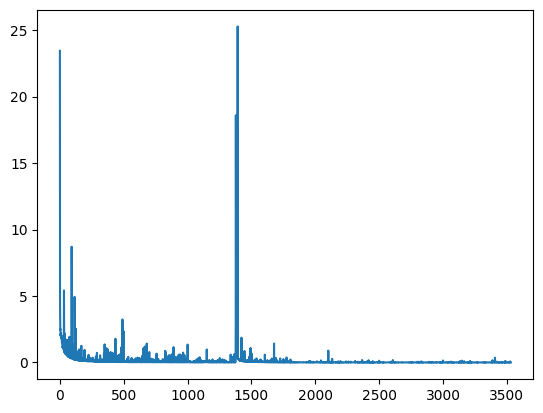

In [57]:
i = 0
loss_list, loss_pde1, loss_pde2 = [], [], []
for loss in l_lst:
    loss_list.append(loss.to('cpu').detach().numpy())
for loss in l_lst1:
    loss_pde1.append(loss.to('cpu').detach().numpy())
for loss in l_lst2:
    loss_pde2.append(loss.to('cpu').detach().numpy())
np.save('loss.npy', loss_list)
np.save('loss_pde1.npy', loss_pde1)
np.save('loss_pde2.npy', loss_pde2)
plot_loss(l_lst)

In [58]:
import joblib
joblib.dump(water_net.state_dict(), 'model_water.joblib')
joblib.dump(bed_net.state_dict(), 'model_seabed.joblib')

['model_seabed.joblib']